In [2]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using Graphs


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [3]:
function matrix_breakdown(A, B)
    nVerts=size(A)[2]
    nEdges=size(A)[1]
    nCells=size(B)[1]
    edgesP=vec((abs.(ones(nCells)'*B)))
    vertsP=vec((0.5.*edgesP'*abs.(A))')
    edgesB=vec(abs.(A*(ones(nVerts).-vertsP)))
    edgesI=vec(ones(nEdges).-edgesB.-edgesP)
    vertsI=vec(ones(nVerts)-vertsP)
    cellsB=vec(abs.(abs.(B)*edgesP))
    cellsB[findall(x->x!=0,cellsB)].=1
    cellsI=ones(nCells)-cellsB
    
    edgesI=((abs.(B))'*Diagonal(cellsI)*abs.(B))*edgesI
    edgesI[findall(x->x!=0, edgesI)].=1


    vertsI=((abs.(A))'*Diagonal(edgesI)*abs.(A))*vertsI
    vertsI[findall(x->x!=0, vertsI)].=1


    return edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI
end

matrix_breakdown (generic function with 1 method)

In [331]:
f=Glob.glob("pseudo2D/500_cells/Final_config_Hfixed","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("systemDataFinal*L₀=2.89*ΓA=-0.5_*Γa=0.1.jld2",f)[end]
@unpack R, matrices, params = load(ff)
@unpack nCells,nEdges,nVerts, Γa, ΓA, ΓL, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPositions,cellPressures,cellVertexOrders, cellEdgeCount, edgeLengths,edgeTangents,vertexAreas,A,Ā,B,B̄,C, ϵ, cellHeights = matrices
sort(norm.(edgeTangents))
mkpath(datadir(f,"plots"))

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\pseudo2D\\500_cells\\Final_config_Hfixed\\plots"

In [332]:
edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=matrix_breakdown(A,B)
# edgesP=vec((abs.(ones(nCells)'*B)))
# cellsB=vec(abs.(abs.(B)*edgesP))
# cellsB[findall(x->x!=0,cellsB)].=1
# cellsI=ones(nCells)-cellsB

h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)

Fz=cellAreas.*Ph .+ cellPerimeters.*(ΓA/2 .+ Th)



cellVolumes=cellAreas.*h
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
shapeParam3D=cellSurface./(cellVolumes.^(2/3))


Peff2D=(cellPressures .+ cellTensions.*cellPerimeters./(2.0.*cellAreas))
Peff3D= (1.0./(3.0*cellVolumes)).* (2.0 .* cellPressures.*cellAreas .+ cellTensions.*cellPerimeters .+ h.*Fz)
#Peff3DV=Ph .+ (2/3).*Th.*(2.0.*cellAreas.+h.*cellPerimeters)./cellVolumes .+ (1/3).*(ΓA.*(h.*cellPerimeters)./cellVolumes .+ Thc.*cellPerimeters./cellVolumes
Peff3DV= (1.0./(3.0*cellVolumes)).* (3.0.*Ph.*h.*cellAreas.+  2.0 .*Th.*(2.0.*cellAreas .+ h.*cellPerimeters) .+ Thc .*cellPerimeters .+2.0.* h.*(cellPerimeters.*(ΓA/2)))


cellQ, cellJ=makeCellQandJ(params, matrices)
ss2D=cellTensions.*cellPerimeters.*(sqrt.(-det.(cellJ)))./cellAreas
ssZ=Peff3D.- Peff2D./h



scrit=[2*sqrt(n*tan( pi /n )) for n in 4:10]

spdiff=shapeParam2D
spdiff[cellEdgeCount.==4].-=scrit[1]
spdiff[cellEdgeCount.==5].-=scrit[2]
spdiff[cellEdgeCount.==6].-=scrit[3]
spdiff[cellEdgeCount.==7].-=scrit[4]
spdiff[cellEdgeCount.==8].-=scrit[5]

spdiff_norm=spdiff
spdiff_norm[cellEdgeCount.==4]./=scrit[1]
spdiff_norm[cellEdgeCount.==5]./=scrit[2]
spdiff_norm[cellEdgeCount.==6]./=scrit[3]
spdiff_norm[cellEdgeCount.==7]./=scrit[4]
spdiff_norm[cellEdgeCount.==8]./=scrit[5]

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))

Peff3D

500-element Vector{Float64}:
  1.88482979617126e-5
  0.00022416448704664775
 -0.00029524963799284186
 -2.0535596799111953e-5
  0.0022990641146257407
 -0.00022661377606375148
 -0.0002151934335625975
  0.00027123431090319655
 -6.861874675425794e-5
 -0.00030417838042948387
  ⋮
 -0.0003587287348396833
 -0.00026981184545313096
  0.00019440486799837513
 -0.0003235677261199608
 -0.00013966612880364742
 -0.00029160098309894154
  0.000232303607640127
  0.000170966526656933
 -0.000356157466482265

In [333]:
edgeTensions=abs.(B)'*cellTensions

1579-element Vector{Float64}:
 0.0003223604003962377
 0.0009737822371695404
 0.0006946229960184819
 0.000675491419008703
 0.006511830371083077
 0.0008659941693295453
 9.274952984866802e-5
 0.0005982918869799625
 0.00023998622505802536
 1.0492307830345382e-6
 ⋮
 0.017373774835282366
 0.014389305430676708
 0.014340803608846972
 0.0015770812123908906
 0.001130573830378026
 0.001123921012025117
 0.00019770907595796638
 0.0002745932865962919
 0.00010284814246899754

In [334]:
thresholdEdges=zeros(nEdges)
thresholdEdges[findall(x->abs.(x)>0.002,edgeTensions)].=1


Ith=dropzeros((A)'*Diagonal(thresholdEdges)*(A))

1080×1080 SparseMatrixCSC{Float64, Int64} with 608 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠔⠠⠄⠀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⡆⠄⡀⠠⠀⠀⠀⠄⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⢈⠀⠀⠀⠀⡠⡂⠀⠒⠁⠀⠁⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⠀⠀⠁⢀⠈⠀⠀⠄⎥
⎢⠀⠀⠀⠀⠱⠆⠀⠀⠀⠄⠠⠀⠈⠀⠀⠀⠀⠂⠂⠀⠀⠀⠀⠀⠀⠠⠀⠀⠁⠐⠈⠁⠀⠐⠂⠀⠈⠂⠀⠀⎥
⎢⠀⠀⡀⢀⠀⠀⠐⢄⠀⡀⠀⠀⠀⠀⢂⠀⢀⠀⠀⠀⠀⠀⠀⠀⠠⠀⡀⠀⠀⠀⠀⢂⠄⠀⠠⠀⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠄⠀⠠⠑⢄⠀⠀⠀⠀⠈⠸⠀⠡⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⡁⠀⠑⠄⠐⠂⠢⠀⠌⠄⠁⠠⎥
⎢⠈⠀⠀⠀⠀⠂⠀⠀⠀⠀⠑⢀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠂⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠐⠀⠀⠀⠀⎥
⎢⠀⠀⠠⠪⠂⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠐⠀⠀⡀⠀⠀⠀⠀⠄⠀⠄⠠⠀⠀⢀⠀⠀⠀⠀⠂⠀⠀⎥
⎢⠐⡁⢠⠀⠀⠀⠈⠐⣂⡀⠀⠀⠀⠀⠑⢄⢀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠆⢀⠀⠃⢐⠂⠀⢁⡀⠀⠈⠀⎥
⎢⠀⠁⠁⠀⠠⠀⠀⠐⠄⡀⠀⠀⠀⠀⠀⠐⠑⢄⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠈⠀⠀⠁⢀⠈⢑⡄⠀⠈⢀⎥
⎢⠑⠀⠁⠀⠈⠀⠀⠀⠈⠊⠀⠀⠐⠀⠀⠈⠀⠀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠈⠀⠀⠊⠁⠓⠀⎥
⎢⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠈⠀⠀⠠⠀⠀⠀⠀⠀⠀⠁⠄⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢀⠀⠈⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⡀⠀⠂⠀⠀⠀⠐⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⡀⠀⠐⣤⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠠⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⎥
⎢⠀⠀⠀⠀⢁⠀⠀⠀⠁⠈⠀⠀⠀⡁⠈⢁⡀⠀⠀⠀⠀⠁⠀⢀⠀⠀⠀⠀⠁⢀⠀⠈⢀⠈⠁⠀⠀⠀⠀⠀⎥
⎢⠠⠦⡀⢀⠆⠀⠠⢀⠑⠄⠀⠀⠀⠀⠤⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠑⢄⠀⠤⠀⢀⠄⠀⠠⠀⎥
⎢⠀⠡⠀⠀⢀⠀⠀⠁⠰⠀⠄⠀⠀⠐⠰⠐⠁⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠐⠀⡄⠑⢄⠀⠀⠀⠀⠈⠀⎥
⎢⠀⠂⠁⢀⠈⠀⠀⠂⠈⠂⢀⠀⠀⠀⠄⢀⢆⢀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠁⠀⠀⢀⠀⠀⠑⢄⠀⠀⠀⠐⎥
⎢⠀⠀⠂⠀⠢⠀⠀⠈⠂⠅⠀⠀⠠⠀⠀⠈⠀⠉⠎⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠁⠀⠀⠀⠀⠟⠅⠀⠀⎥
⎣⠀⠁⠀⠄⠀⠀⠀⠀⠁⡀⠀⠀⠀⠀⠂⠀⠂⢀⠙⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠂⠂⠀⢀⠀⠀⠀⠑⢄⎦

In [335]:
evalIth, evecIth=eigen(Matrix(Ith))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
1080-element Vector{Float64}:
 -1.6622693884156013e-15
 -1.4021787094717477e-15
 -1.2724374483818772e-15
 -1.1299894772897995e-15
 -1.1102230257691242e-15
 -8.619327581629273e-16
 -5.216969719089262e-16
 -4.823158365315749e-16
 -4.779646980398754e-16
 -3.8767322240591444e-16
  ⋮
  5.173595248343817
  5.247749053863324
  5.284439330418198
  5.38109162173608
  5.494050944847406
  5.516066733560978
  5.57820028574593
  5.652309471847274
  5.669033083515537
vectors:
1080×1080 Matrix{Float64}:
  0.0           0.0          0.0       …   0.0           0.0
  0.0           0.0          0.0           0.0           0.0
  0.0           0.0          0.0           0.0           0.0
  0.0           0.0          0.0           0.0           0.0
  0.0           0.0          0.0           0.0           0.0
  0.0           0.0          0.0       …   0.0           0.0
  0.0           0.0          0.0           0.0           0.0
  0.0        

In [336]:
evalIth[abs.(evalIth).>1e-6]

169-element Vector{Float64}:
 0.017050440087207266
 0.06598012474295455
 0.07740285169704342
 0.10507335622902686
 0.13189532610348734
 0.18634098778355296
 0.1870742018132695
 0.19570163052777456
 0.22551866471560322
 0.23420840691064196
 ⋮
 5.173595248343817
 5.247749053863324
 5.284439330418198
 5.38109162173608
 5.494050944847406
 5.516066733560978
 5.57820028574593
 5.652309471847274
 5.669033083515537

In [ ]:
Point2f.(R)

1080-element Vector{Point{2, Float32}}:
 [2.259918, -1.6014808]
 [-6.5823655, 2.657339]
 [-4.8200436, 4.82583]
 [1.4573045, 5.185947]
 [3.4146285, 6.062268]
 [0.49673942, -6.785293]
 [0.7116167, 0.32850593]
 [2.777359, 1.694999]
 [-3.3119514, -2.7108831]
 [5.2121377, 0.85967016]
 ⋮
 [4.0732265, -1.2647699]
 [2.0128286, 4.5889497]
 [2.1237967, 4.9904966]
 [-0.5043609, 2.3961852]
 [-1.0178876, 2.7337482]
 [2.3761342, -1.712317]
 [2.928099, -1.4573992]
 [0.3317945, 4.4943542]
 [0.3738145, 4.8783455]

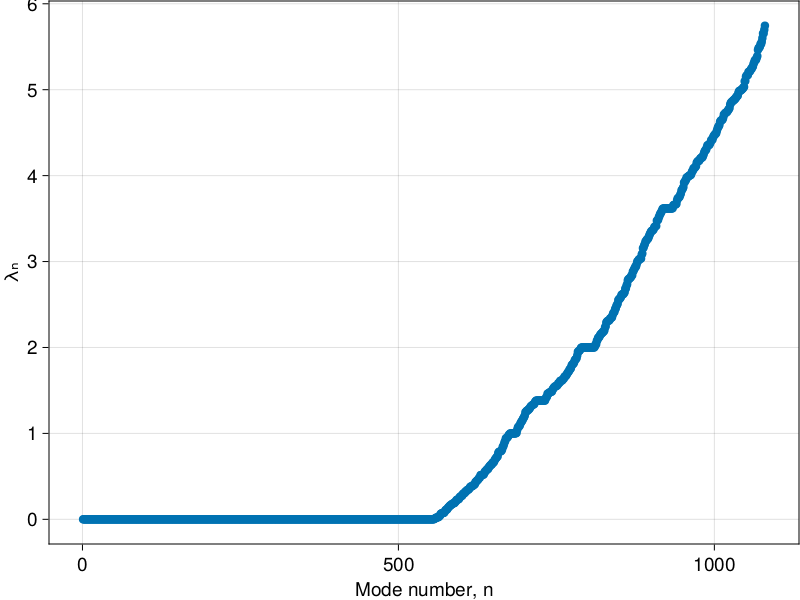

CairoMakie.Screen{IMAGE}


In [251]:
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
a1=Axis(fig[1,1],  xlabel="Mode number, n", ylabel="λₙ")

scatter!(abs.(evalIth))

display(fig)

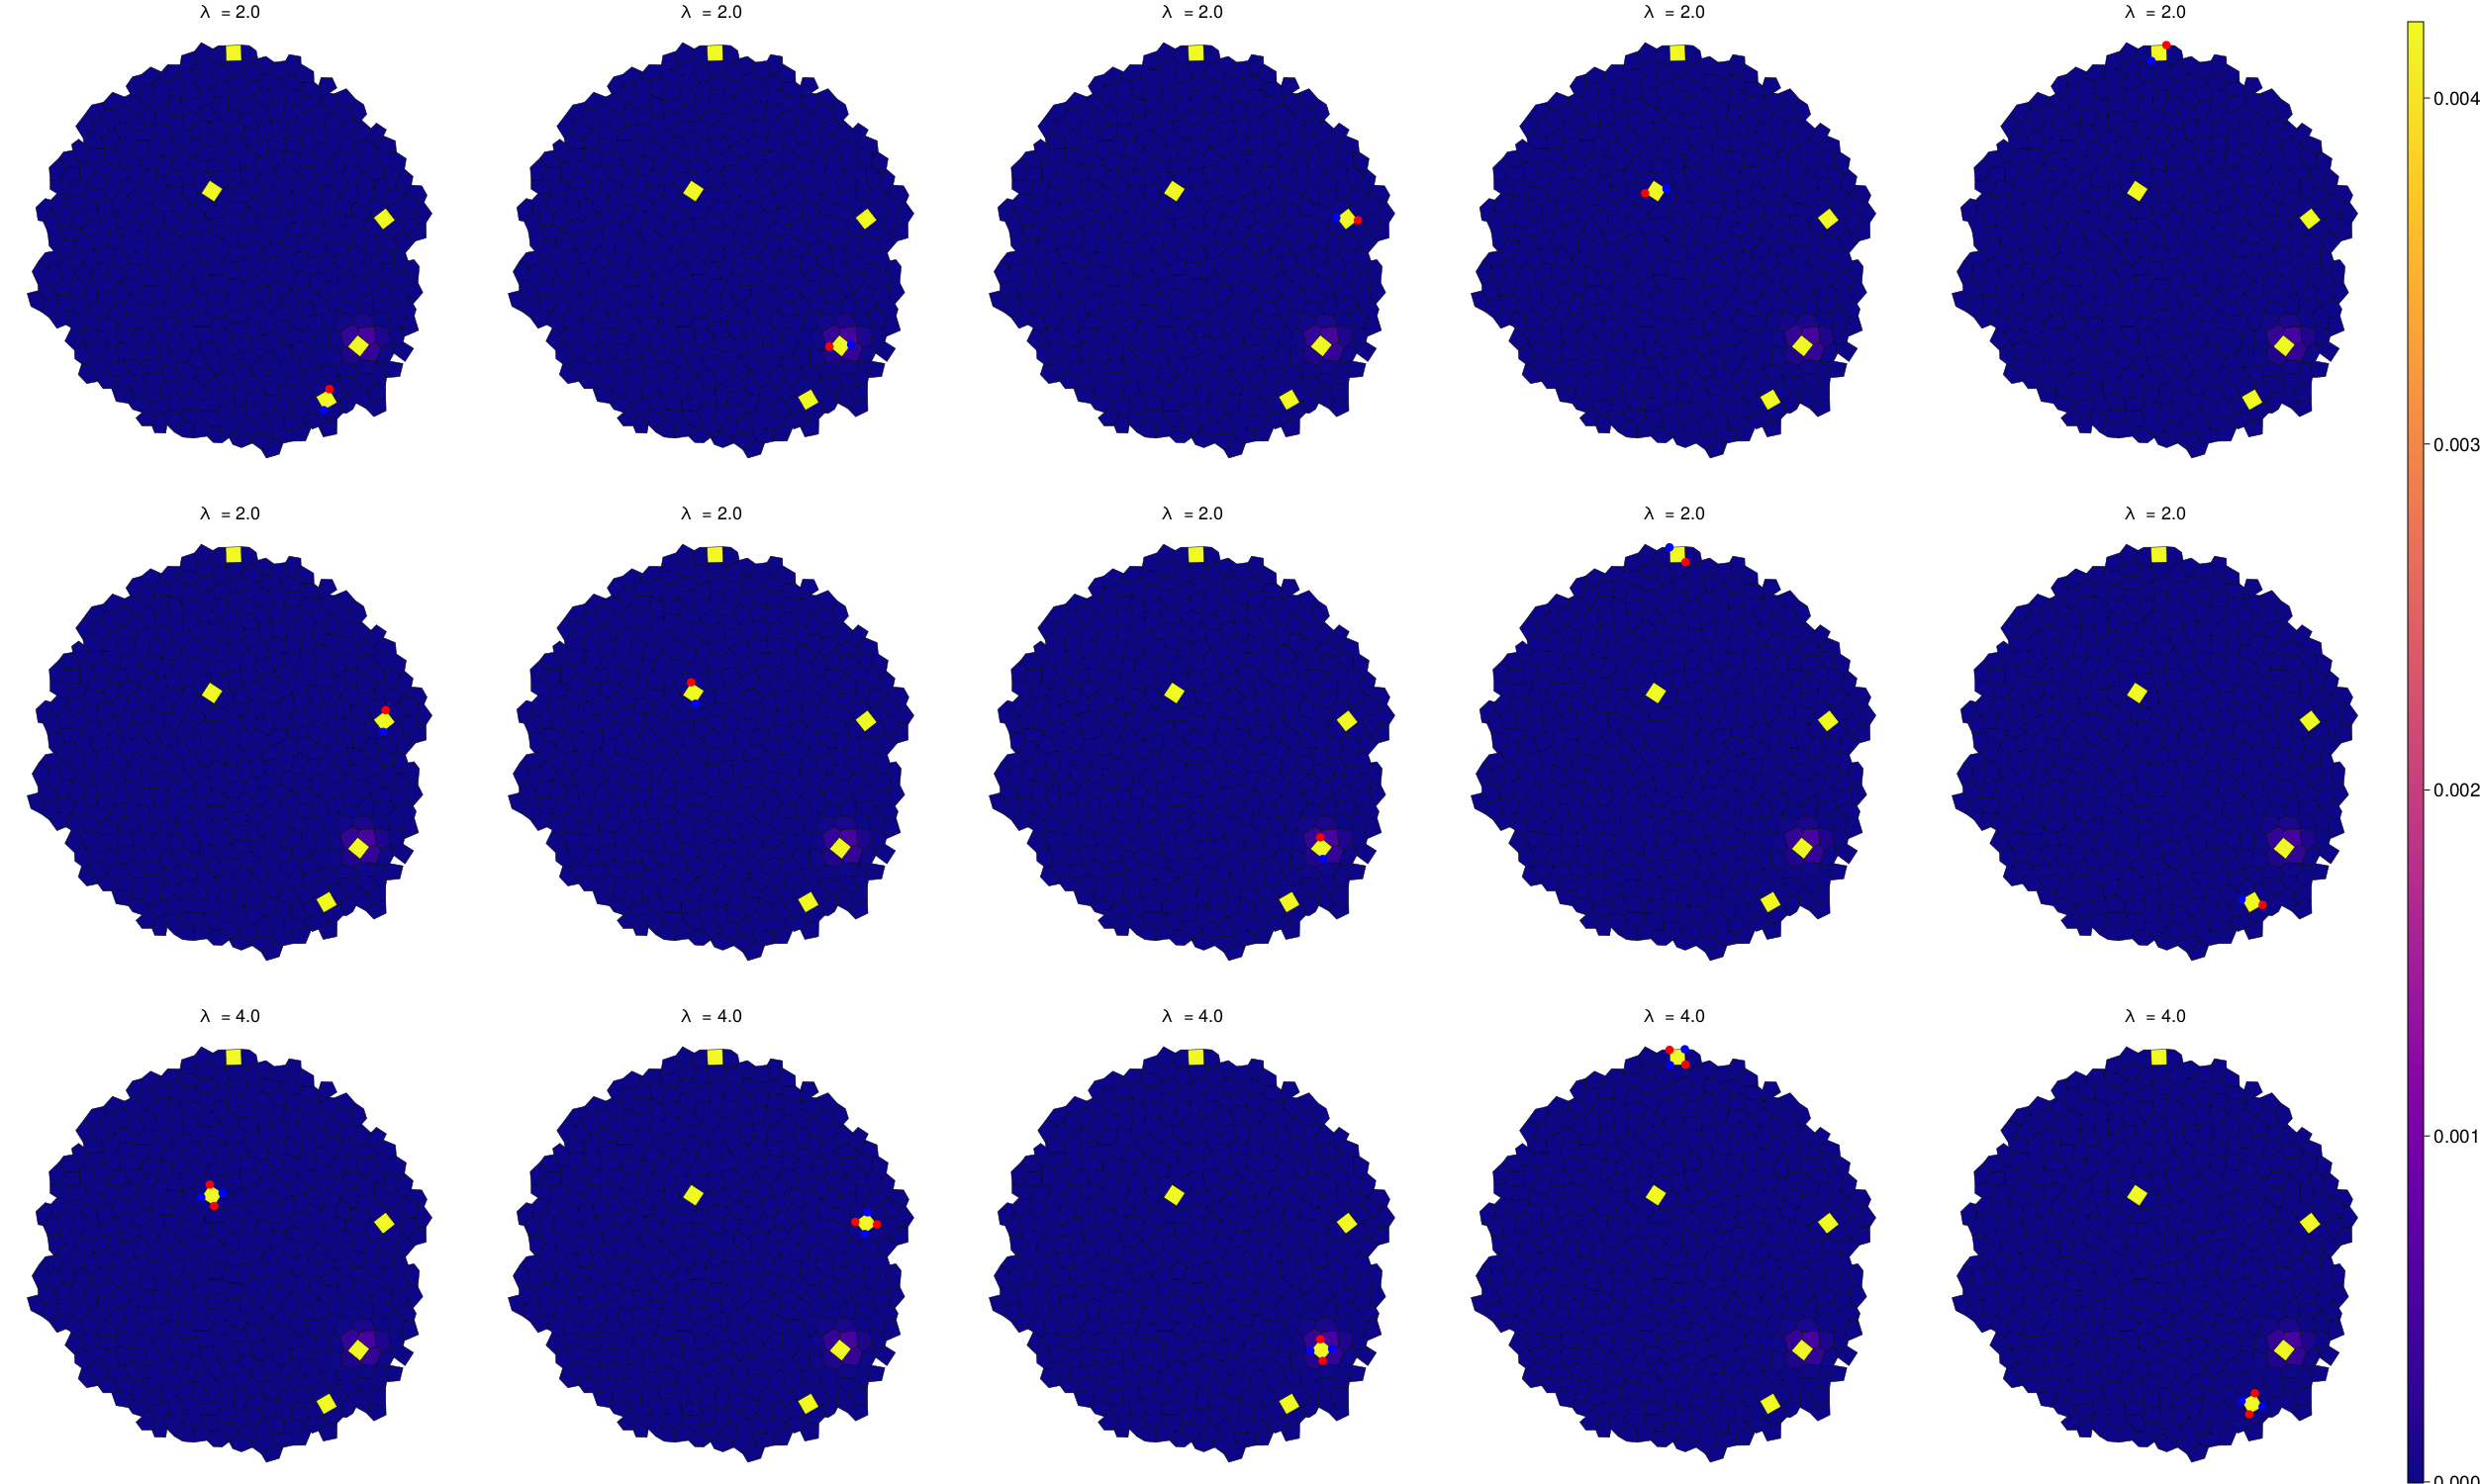

CairoMakie.Screen{IMAGE}


In [215]:
cellPolygons = makeCellPolygons(R,params,matrices)
n=200



fig = Figure(resolution=(1500,1500))
#fig[1,1]=GridLayout()
lims=(minimum(cellTensions), maximum(cellTensions))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Arial", fontsize=19)
for row in 1:3

    a1=Axis(fig[row,1],aspect=DataAspect())
    a2=Axis(fig[row,2],aspect=DataAspect())
    a3=Axis(fig[row,3],aspect=DataAspect())
    a4=Axis(fig[row,4],aspect=DataAspect())
    a5=Axis(fig[row,5],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    hidedecorations!(a3)
    hidespines!(a3)
    hidedecorations!(a4)
    hidespines!(a4)
    hidedecorations!(a5)
    hidespines!(a5)


    for i=1:nCells
        poly!(a1,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
        poly!(a2,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
        poly!(a3,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
        poly!(a4,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
        poly!(a5,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
    end
    scatter!(a1, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-1)])], color=evecIth[:,nVerts-(((4-row)*5)-1)][findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-1)])], colormap=:bwr)
    scatter!(a2, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-2)])], color=evecIth[:,nVerts-(((4-row)*5)-2)][findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-2)])], colormap=:bwr)
    scatter!(a3, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-3)])], color=evecIth[:,nVerts-(((4-row)*5)-3)][findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-3)])], colormap=:bwr)
    scatter!(a4, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-4)])], color=evecIth[:,nVerts-(((4-row)*5)-4)][findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-4)])], colormap=:bwr)
    scatter!(a5, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-5)])], color=evecIth[:,nVerts-(((4-row)*5)-5)][findall(x->abs.(x)>1e-6, evecIth[:,nVerts-(((4-row)*5)-5)])], colormap=:bwr)

    #Label(fig[2*row,col,Bottom()],L"\lambda_{"*string(2*nCells-(ns[row][col]-1))*"} = "*@sprintf("%.5E", sNF[ns[row][col]]^2),fontsize = 24)

    #hidedecorations!(ax22)
    #hidespines!(ax22)
    Label(fig[row,1,Top()],"λ  = "*string(round(evalIth[nVerts-(((4-row)*5)-1)], digits=3)),fontsize = 18)
    Label(fig[row,2,Top()],"λ  = "*string(round(evalIth[nVerts-(((4-row)*5)-2)], digits=3)),fontsize = 18)
    Label(fig[row,3,Top()],"λ  = "*string(round(evalIth[nVerts-(((4-row)*5)-3)], digits=3)),fontsize = 18)
    Label(fig[row,4,Top()],"λ  = "*string(round(evalIth[nVerts-(((4-row)*5)-4)], digits=3)),fontsize = 18)
    Label(fig[row,5,Top()],"λ  = "*string(round(evalIth[nVerts-(((4-row)*5)-5)], digits=3)),fontsize = 18)



    colsize!(fig.layout,1,Aspect(1,1.0))
    colsize!(fig.layout,2,Aspect(1,1.0))
    
    colsize!(fig.layout,3,Aspect(1,1.0))
    colsize!(fig.layout,4,Aspect(1,1.0))
    
    colsize!(fig.layout,5,Aspect(1,1.0))
    




    # if col==1
    #     Label(fig[2*row-1,1,Left()],"Area",fontsize =24, rotation=π/2)
    #     Label(fig[2*row,1,Left()],"Perimeter",fontsize = 24, rotation=π/2)
    # end
end

Colorbar(fig[1:3,6],limits=Tlims, colormap=:plasma,flipaxis=true)

#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"paper_figures","eigenmodes_Y.png"),fig)

display(fig)

Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"plots","Iepsilon_Modes_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
#end


In [338]:
cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices


lims=(minimum(cellTensions), maximum(cellTensions))
mkpath(datadir(f,"plots", "L_ep_modes_L0_2.89"))

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Arial", fontsize=19)

for m in 1:169
    fig = Figure(resolution=(1000,1000))

    a11=Axis(fig[1,1],aspect=DataAspect())

    hidedecorations!(a11)
    hidespines!(a11)


    for i=1:nCells

        poly!(a11,cellPolygons[i],color=cellTensions[i], colormap=:plasma, colorrange=lims,strokecolor=(:black,1.0),strokewidth=0.5)
    end

    n=nVerts+1-m

    scatter!(a11, Point2f.(R)[findall(x->abs.(x)>1e-6, evecIth[:,n])], color=evecIth[:,n][findall(x->abs.(x)>1e-6, evecIth[:,n])], colormap=:bwr)

    #scatter!(a11, Point2f.(R)[unique(getindex.(findall(x->abs.(x)>1e-6, evecIth[:, (nVerts-73):end]), 1))], color=:lime)

    colsize!(fig.layout,1,Aspect(1,1.0))



    Colorbar(fig[1,2],limits=lims,colormap=:plasma,flipaxis=true)


    Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)
    #save(datadir(f,"eigenmodes","Stress.png"),fig)
    save(datadir(f,"plots", "L_ep_modes_L0_2.89","L_ep_eigenmode_n_"*string(n)*"_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
end

#display(fig)

In [347]:
evalBth, evecBth=eigen(Matrix(dropzeros!(B*Diagonal(thresholdEdges)*B')))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
500-element Vector{Float64}:
 -4.563058149963753e-15
 -2.6052432275447966e-15
 -2.2564509477148838e-15
 -1.9629484025827913e-15
 -1.4345767835399186e-15
 -1.027958002461064e-15
 -7.599263746380433e-16
 -7.317403281882021e-16
 -4.78149978967749e-16
 -4.600086916655516e-16
  ⋮
  7.99814187336871
  8.105963394071429
  8.455145716212801
  8.539514948510314
  8.674029677940872
  8.70852341802765
  8.77698586157151
  9.333856313256373
  9.606574574059549
vectors:
500×500 Matrix{Float64}:
  5.11743e-16  -2.54657e-15  -4.64906e-16  …   5.55405e-6    0.000120138
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  0.0           0.0           0.0              0.0           0.0
  2.91434e-16  -1.73472e-15  -1.52656e-16     -0.755803      0.250498
  5.79398e-16  -2.41474e-15  -4.09395e-16  …  -5.66229e-6    0.00013227
  0.0           0.0           0.0    

In [349]:
evalBth[abs.(evalBth).>1e-6]

126-element Vector{Float64}:
 0.01050085168504083
 0.024046073655241366
 0.035299199274200256
 0.13887853410231807
 0.1804601447480374
 0.19637181223270672
 0.2087121525220798
 0.22596800371472994
 0.2578638448944791
 0.3438791956164962
 ⋮
 7.99814187336871
 8.105963394071429
 8.455145716212801
 8.539514948510314
 8.674029677940872
 8.70852341802765
 8.77698586157151
 9.333856313256373
 9.606574574059549

In [328]:
unique(getindex.(findall(x->abs.(x)>1e-6, evecIth[:, (nVerts-73):end]), 1))

82-element Vector{Int64}:
  23
  29
  63
 121
 204
 215
 234
 249
 362
 424
   ⋮
 967
 859
 971
  97
 361
 174
 175
 219
 764

In [32]:
C'*(cellAreas.*Ph.+cellPerimeters.*(0.5.*ΓA .+ Th))

#cellAreas.*Ph .+ cellPerimeters.*(ΓA/2 .+ Th)

##We average over vertices for the height sum_k C_ik Fz_i = 0

sum(Fz)
#

7.988813244264037e-7

In [1]:
Fz

UndefVarError: UndefVarError: `Fz` not defined

In [16]:
sum(cellAreas.*(Peff3D.-((2/3).*Peff2D./h)))

3.637411019133814e-7

In [9]:
cellPolygons = makeCellPolygons(R,params,matrices)


500-element Vector{Vector{Point2{Float64}}}:
 [[3.3260884243223194, -7.098795899008965], [3.076586786301776, -7.193117461310821], [3.0322305801069236, -7.135852567344938], [2.81499781473325, -6.9362450476978275], [2.729290575738469, -6.742081231803952], [2.951191376378483, -6.607813224251639], [3.4741858177656053, -6.5493168426026065], [3.6915387469933467, -6.837325491024234]]
 [[2.2599179248039594, -1.6014808568667118], [1.7498374367202978, -1.3077159804412224], [1.8095255931038603, -1.0590492559671847], [1.9275362149464332, -0.7743520137289538], [2.245699715074351, -0.8062251157996961], [2.4672974605628033, -0.9060519435819074], [2.278897231453666, -1.5695340594128957]]
 [[-6.582365605919031, 2.657339133111117], [-6.980893398161414, 2.7584136079992745], [-6.785902400514578, 3.2676840927524458], [-6.206177649627568, 3.253741491394965], [-6.203573694199282, 2.7344572070285635]]
 [[-3.037387511621658, 6.835009624295171], [-2.6687771998153953, 6.712030411075529], [-2.5618636759798346, 6.

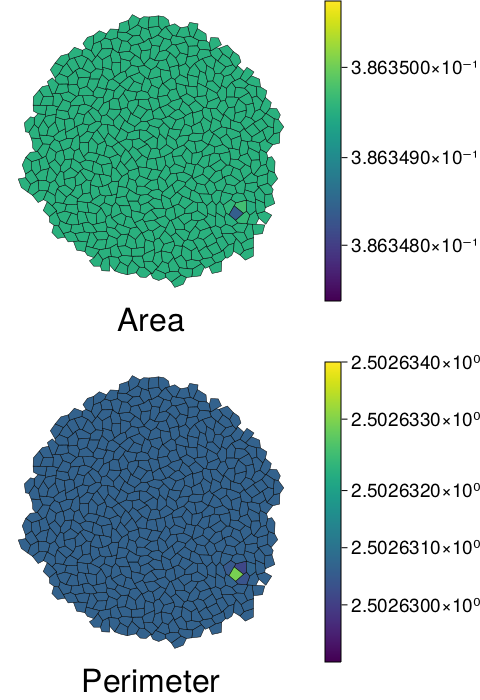

In [5]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells]))-1e-6, maximum(abs.(cellAreas[1:nCells]))+1e-6)
Levlims=(minimum(abs.(cellPerimeters[1:nCells]))-1e-6, maximum(abs.(cellPerimeters[1:nCells]))+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=:viridis,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=:viridis,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string("Area"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string("Perimeter"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","Area_Perimeter.png"),fig)
save(datadir(f,"plots","AL_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [5]:
G=dropzeros!(sparse([Diagonal(4 .*Γa .+cellHeights.^2) Diagonal(2 .*Γa .*cellHeights)
Diagonal(2 .*Γa .*cellHeights) Diagonal(2 .*ΓL .+ Γa .*cellHeights.^2)]))
M=makeM(matrices)
Lv=M'*G*M

1080×1080 SparseMatrixCSC{SMatrix{2, 2, Float64, 4}, Int64} with 13506 stored entries:
⎡⣻⣾⡜⣲⡿⣽⣖⣻⡼⢥⣻⡛⡳⣷⣷⣷⠶⢯⢽⣽⣛⣒⢜⣟⣸⣷⣶⣳⢴⣏⣺⡶⢧⡷⣽⠿⣿⠍⠦⠌⎤
⎢⢲⣩⡑⢌⠟⢼⣾⣯⡿⡳⢳⣷⣯⡿⣌⣟⣯⢚⡷⢻⡻⠶⢷⣾⡿⣿⣯⡿⣟⣽⠛⣏⡮⢽⣉⣯⡫⢾⠮⡖⎥
⎢⣟⣯⣛⣅⠿⣧⢎⣩⠛⠿⣼⣮⣍⢿⢩⣙⠀⠿⠻⢦⣾⣬⣭⡿⡵⢭⢯⢇⢻⣸⡿⠃⢻⠾⠋⣻⣿⠖⡫⣧⎥
⎢⣼⣹⡾⣿⡎⣱⢱⣶⠮⡑⣹⢿⠿⣗⢷⡭⣥⣅⡬⣟⣓⠺⢛⡿⣮⡶⡿⣼⣷⣙⣯⢯⢽⣯⣲⢯⡊⡌⢑⠣⎥
⎢⠖⣏⢿⡫⣿⡄⢎⠣⠛⢄⡲⡘⠱⢐⡎⡾⠿⢿⣿⣆⣒⢃⣔⡜⣸⡭⡿⡇⡋⠟⡿⡿⢞⣾⠿⡞⢯⣵⣯⡿⎥
⎢⣿⠺⢽⣶⡲⣿⣷⣞⣘⠪⢿⣷⣲⢼⣏⡍⠃⢔⣚⣽⣿⣿⣿⡾⣏⣟⣿⡕⣌⢔⠏⢈⣠⠁⡐⠲⡴⣁⣊⣹⎥
⎢⢽⣮⣯⡿⣧⣝⢿⢧⢑⢂⣘⣞⣵⣿⠱⠬⡓⠅⠛⣎⣡⣯⡿⡿⡿⢒⣞⣻⠾⣫⡎⠿⢜⢒⡂⠪⠙⢞⣷⠗⎥
⎢⢽⣿⣦⢽⣇⢲⡝⡷⣪⡭⡏⠽⡑⡆⣻⣾⢥⣵⡩⡼⠡⠪⡭⠣⢵⢗⢨⠷⠷⢷⣪⣻⣼⡯⢉⣍⣵⠨⣸⡄⎥
⎢⡼⣇⣫⢛⣤⡄⠅⢿⣿⣇⢉⢄⠝⠌⢅⣷⢿⢗⣵⡄⡀⡈⠐⠹⢑⡲⡟⢭⢘⢟⡿⣿⡵⢿⢟⣿⡧⣴⢜⣃⎥
⎢⣗⣷⣽⣋⠻⣆⣦⢯⠻⢿⣞⣼⡻⢤⣃⡮⠑⠿⠻⣦⣑⠅⣄⡜⣱⣚⣤⣂⡹⢋⢿⠊⠯⡿⠟⠭⠿⠿⠟⠇⎥
⎢⢻⢸⢻⡎⡚⣿⣹⡘⠼⢘⣿⣿⡥⣾⡡⡂⡀⠨⠕⠜⡿⣯⣥⢟⣖⢮⣗⢩⠽⣽⣄⠈⠘⡲⠀⠸⡖⡆⠌⠥⎥
⎢⣶⢵⣹⣷⣧⡿⣿⡴⣐⠽⣻⡿⣿⡯⠧⡋⣔⡀⣀⠽⣥⢟⢵⣷⣻⠯⠭⡴⢶⣂⢃⢄⣰⠂⠨⠅⡀⠠⡸⣗⎥
⎢⢶⣾⣿⣯⡕⣏⢪⡿⡖⡾⣯⢽⢻⢋⢵⢗⢱⡰⣱⢺⡸⣝⡿⡞⣕⣽⣗⡵⠔⡖⣙⢡⢳⠯⣴⠸⣁⣨⢪⣳⎥
⎢⢼⣻⣯⡿⠯⢗⣛⣯⠿⠯⢟⠿⣾⣹⢦⡖⡟⣍⠠⢻⡝⣙⢃⡧⢝⡽⣿⣿⣣⡬⡳⢙⡰⣉⠑⠐⢱⠁⣓⡆⎥
⎢⡴⢷⣟⣽⣛⣲⣝⢻⣯⠌⢂⢝⡾⣣⢽⣇⣶⢔⡷⢊⣗⣧⠸⢳⢰⠥⡉⡾⣿⣿⡘⢹⣈⠨⢓⣥⡌⣩⠘⡁⎥
⎢⢺⡾⡿⢤⠿⠋⡯⣟⣿⡯⡋⢁⣮⡍⣮⣺⣿⣯⡻⠓⡀⠙⠉⢔⠗⣘⣝⢊⣖⣈⣿⣿⡷⡾⣳⣵⣟⠟⣠⣡⎥
⎢⢭⡷⣎⣏⣻⡖⡷⣷⣺⣵⠄⠚⢲⢑⡶⡿⣵⣏⣯⡧⢲⡠⠰⠚⡽⡖⡔⢪⡂⡘⣹⡯⣛⢜⣯⣫⢖⡌⢭⢬⎥
⎢⣷⡟⡧⣼⣯⣠⡼⣞⣻⠧⢰⡈⡨⡈⡇⢴⣿⣵⡟⡅⣀⡀⠆⠆⣐⡛⢑⠀⠝⣴⢝⣾⡯⣻⣿⣿⡼⡬⡸⡖⎥
⎢⡟⠟⣫⣎⢻⠟⡊⠬⢏⣷⠔⢫⣳⢄⡑⡛⢉⣯⣿⡇⠸⠭⠀⡈⡁⣸⠕⠒⡆⣩⣿⠝⡘⠵⡒⡯⢿⣷⡇⠃⎥
⎣⡈⠇⢪⠧⠯⣮⠵⡐⣯⡿⣎⣸⢽⠟⠒⠾⠶⢱⠿⠅⠆⡅⢶⢮⢮⣲⠹⠼⠖⠠⠄⣺⡃⣗⢲⠮⠭⠉⠿⣧⎦

In [6]:


X=makeX(params, matrices)



1000×1080×1080 Array{SMatrix{2, 2, Float64}, 3}:
[:, :, 1] =
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  …  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  …  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 ⋮                                       ⋱  
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0

In [7]:
g=vcat(cellPressures, cellTensions)
gX=Matrix{SMatrix{2,2,Float64,4}}(undef,nVerts,nVerts)
fill!(gX,@SMatrix zeros(2,2))
for α=1:2*nCells
    gX+=g[α]X[α, :,:]
end

In [8]:
H=Matrix(mortar(Lv)).+Matrix(mortar(gX))
evalH, evecH=eigen(H)
evecH=Matrix(qr(evecH).Q)

Lvevals,Lvevecs=LAPACK.syev!('V','U',deepcopy(Matrix(mortar(Lv))))


([-8.14272978408362e-15, -5.718115345664462e-15, -5.355206636517957e-15, -5.204472282561473e-15, -5.1660826823165784e-15, -5.0721631137593744e-15, -5.035896460783442e-15, -5.028418689601204e-15, -4.989995925643855e-15, -4.9245740406915434e-15  …  7.743837030777514, 7.755161306552323, 7.773082868615211, 7.792547716345016, 7.908468377752972, 7.935702175532428, 8.365233314337587, 8.390211131580815, 8.495111597703797, 8.565484607276753], [-0.019116959590074218 -0.004022585735536264 … 0.007685036947958495 -3.9047950557954794e-8; -0.026365178397521553 -0.0036800055715394786 … 0.02061327073249413 4.82907774613534e-9; … ; 0.09957306467959673 -0.008020818652228747 … -1.8207627685159786e-7 1.1535313301346689e-8; -0.15387019811695782 0.003935753399110789 … 9.806259001460157e-8 1.098288657035932e-8])

In [9]:
dUdHH=sum(cellAreas.^2 .+ Γa.*cellPerimeters.^2)
dPdH= 2.0 .*cellAreas.*cellHeights .+ 2.0 .* Γa .*cellPerimeters.-1
dTdH= (ΓA/2.0) .+ Γa.*cellHeights.*cellPerimeters .+ Γa .*(2.0 .*cellAreas .+ cellHeights.*cellPerimeters .-1)
dgdH=vcat(dPdH, dTdH)



1000-element Vector{Float64}:
 0.5654451756539913
 0.5654451761426667
 0.5654451771996012
 0.5654451771960793
 0.565445178931119
 0.5654451762938901
 0.5654451772064091
 0.565445177187534
 0.5654451767474726
 0.5654451770667994
 ⋮
 0.41708542995911513
 0.4170854299701998
 0.4170854299688352
 0.4170854300416387
 0.4170854298998697
 0.41708542996736414
 0.41708542998724585
 0.4170854299434588
 0.4170854299684182

In [10]:
H0=H-(1/dUdHH).*Matrix(mortar((M'*dgdH)*(dgdH'*M)))
#evalH0, evecH0=eigen(H0)
evalH0,evecH0=LAPACK.syev!('V','U',deepcopy(H0))
#writedlm(datadir(f,"evalH_2_T1_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evalH0), ',')
writedlm(datadir(f,"evalH_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evalH0), ',')


In [11]:
Lv0=Matrix(mortar(Lv))-(1/dUdHH).*Matrix(mortar((M'*dgdH)*(dgdH'*M)))
#evalLv0, evecLv0=eigen(Lv0)
evalLv0,evecLv0=LAPACK.syev!('V','U',deepcopy(Lv0))
writedlm(datadir(f,"evalLv_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evalLv0), ',')


In [12]:
D=evecLv0'*Matrix(mortar(gX))*evecLv0
DD=D + Diagonal(evalLv0)
evalDD,evecDD=LAPACK.syev!('V','U',deepcopy(DD))


([-5.975815121243422e-7, -3.994618452612095e-7, -3.0618720967694625e-7, -2.2740981932317476e-7, -2.000929101392602e-7, -1.3510139242866935e-7, -5.8704926257905536e-8, -3.746498890411167e-8, -3.199466671828811e-8, -1.9054675782848102e-8  …  7.737708080851974, 7.751155380024468, 7.772436013913698, 7.792505880064059, 7.901472736999449, 7.935345229957208, 8.356495614073825, 8.386523634206021, 8.491395808853634, 8.5575465955551], [-0.02363814647988738 -0.001996537932398184 … -1.2638498686402324e-11 5.030153983335111e-12; 0.04127690753780863 0.01889830782479172 … -3.08503510167831e-11 3.0241499376310017e-12; … ; -5.4765321379719104e-11 -4.519133321783215e-13 … 0.9999999999999967 5.688813494746878e-10; -5.960309788690018e-12 8.400229731010133e-12 … -5.688812955873541e-10 0.9999999999999982])

In [13]:



#evecmap=[evecDD[:,x]'*(evecLv0'*Matrix(mortar(gX))*evecLv0+Diagonal(evalLv0))*evecDD[:,x] for x in 1:2nVerts]
evmapLv=[evecDD[:,x]'*(Diagonal(evalLv0))*evecDD[:,x] for x in 1:2nVerts]
evmapgX=[evecDD[:,x]'*(D)*evecDD[:,x] for x in 1:2nVerts]

writedlm(datadir(f,"evmapLv_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evmapLv), ',')
writedlm(datadir(f,"evmapgX_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evmapgX), ',')



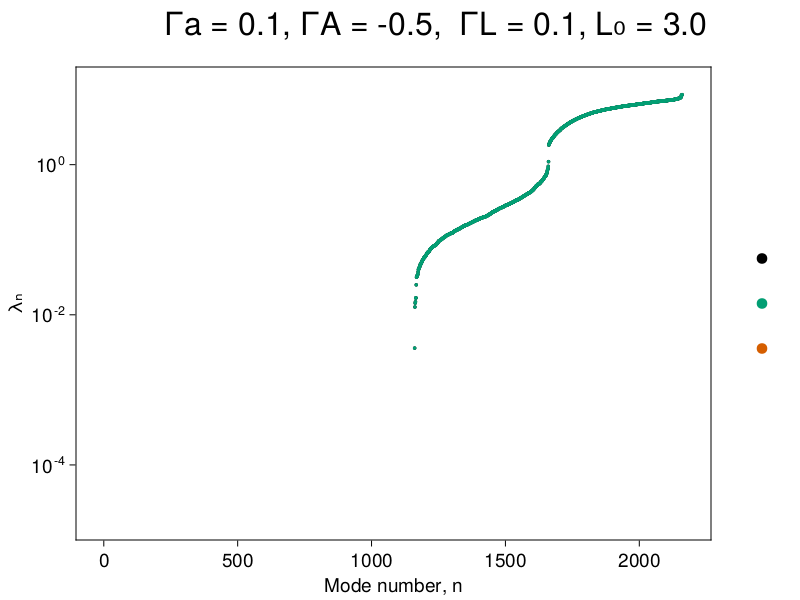

In [17]:
perm=sortperm((abs.(evalH0)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:2*nVerts], ((abs.(evalH0[perm])))[4:2*nVerts], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:2*nVerts], ((abs.(evmapLv[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evmapgX[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],#
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

ylims!(low=1e-5, high=2e1)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"plots","Mode_contributions_1e-5_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

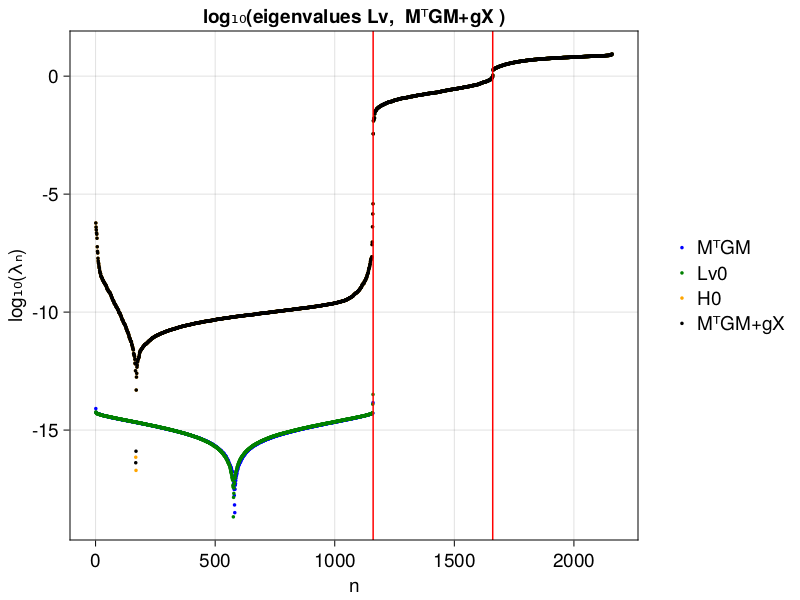

In [18]:
n=LinRange(1, 2*nVerts, 2*nVerts)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="log₁₀(λₙ)", title="log₁₀(eigenvalues Lv,  MᵀGM+gX )")

scatter!(ax,n, log10.(abs.(Lvevals)), color=:blue, label="MᵀGM", markersize=5)
scatter!(ax,n, log10.(abs.(evalLv0)), color=:green, label="Lv0", markersize=5)

scatter!(ax,n, log10.(abs.(evalH0)), color=:orange, label="H0", markersize=5)
scatter!(ax,n, log10.(abs.(evalDD)), color=:black, label="MᵀGM+gX", markersize=5)

vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","Lv_MTGMgX_Evals.png"),fig)
fig

In [16]:
evalDD-evalH0

2160-element Vector{Float64}:
  1.3716893899483502e-16
  2.631055328948084e-16
  4.829133589976708e-15
  2.4322398595940835e-16
 -1.4852293919674609e-15
  5.452224026533843e-17
  2.837966949116588e-16
  3.7748192700977345e-16
  4.799898542864889e-16
 -1.8800065670898647e-16
  ⋮
  3.552713678800501e-14
 -3.907985046680551e-14
 -3.375077994860476e-14
  3.019806626980426e-14
  5.5067062021407764e-14
  3.375077994860476e-14
  1.9539925233402755e-14
  3.197442310920451e-14
 -1.0658141036401503e-14

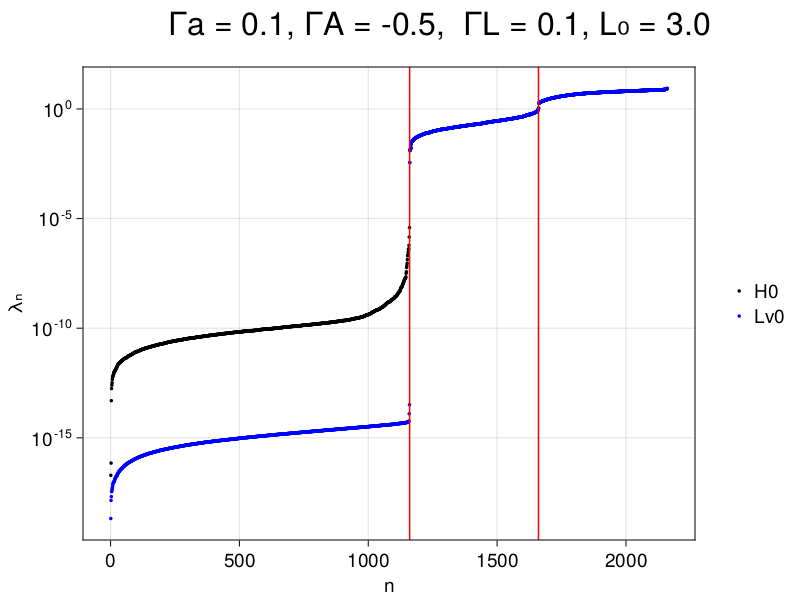

In [19]:
n=LinRange(1, 2*nVerts, 2*nVerts)
perm=sortperm((abs.(evalH0)))
permLv=sortperm((abs.(evalLv0)))
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", yscale=log10)


#scatter!(ax,n, log10.(abs.(evalH)), color=:black, label="MᵀGM+gX", markersize=5)
scatter!(ax,n, (abs.(evalH0[perm])), color=:black, label="H0", markersize=5)

#scatter!(ax,n, log10.(abs.(Lvevals)), color=:blue, label="MᵀGM", markersize=5)
scatter!(ax,n, (abs.(evalLv0[permLv])), color=:blue, label="Lv0", markersize=5)

vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
save(datadir(f,"plots","Lv0_H0_Evals.png"),fig)
fig

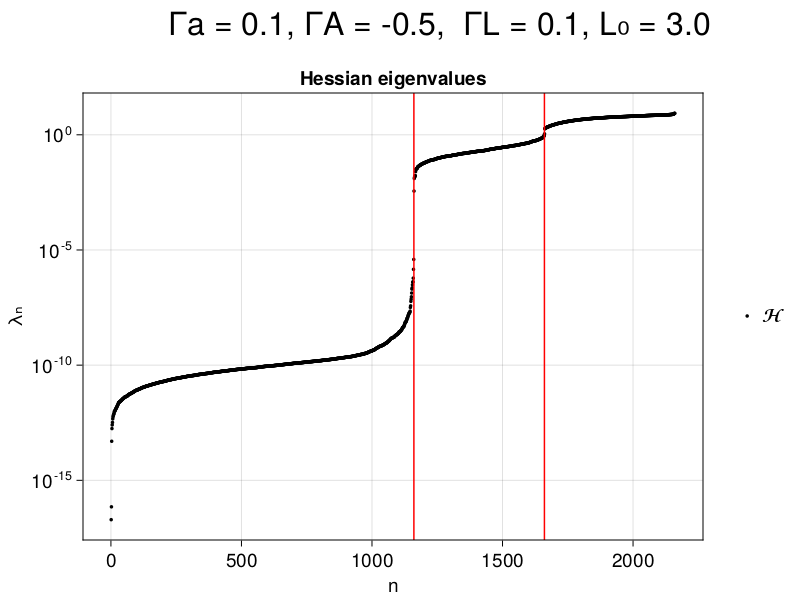

In [22]:
perm=sortperm((abs.(evalH0)))
n=LinRange(1, 2*nVerts, 2*nVerts+1)
nold=LinRange(1, 2*nVerts, 2*nVerts)
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", title="Hessian eigenvalues", yscale=log10)

scatter!(ax,nold, (abs.(evalH0[perm])), color=:black, label=L"\mathcal{H}", markersize=5)


vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
#ylims!(ax, 5e-6, nothing)
save(datadir(f,"plots","Hessian_Evals_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

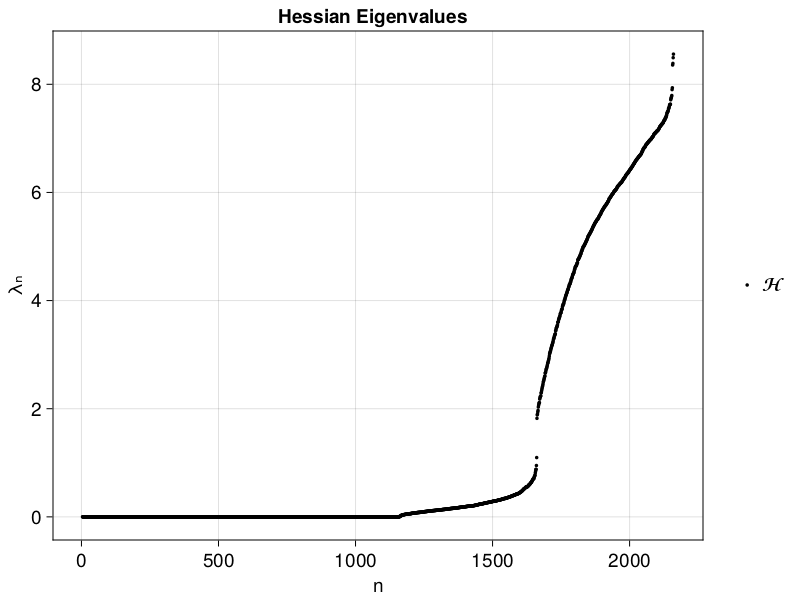

In [23]:
n=LinRange(1, 2*nVerts, 2*nVerts+1)
nold=LinRange(1, 2*nVerts, 2*nVerts)
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", title="Hessian Eigenvalues  ")

scatter!(ax,nold[4:end], (abs.(evalH0))[4:end], color=:black, label=L"\mathcal{H}", markersize=5)



fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","MTGMgX_Evals_Heightdep_non-zero.png"),fig)
fig

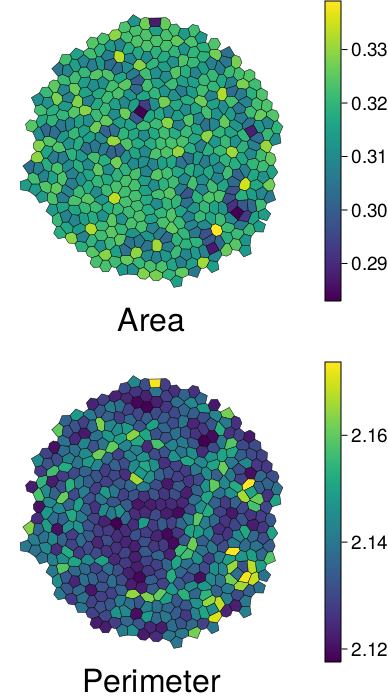

In [394]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells]))-1e-6, maximum(abs.(cellAreas[1:nCells]))+1e-6)
Levlims=(minimum(abs.(cellPerimeters[1:nCells]))-1e-6, maximum(abs.(cellPerimeters[1:nCells]))+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=:viridis,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=:viridis,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string("Area"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string("Perimeter"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","Area_Perimeter.png"),fig)
#save(datadir(f,"plots","AL_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

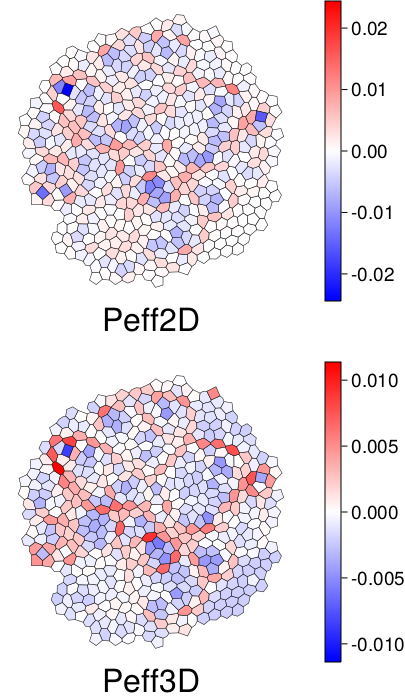

In [101]:
cellPolygons = makeCellPolygons(R,params,matrices)
Pe2Dlims=(-maximum(abs.(Peff2D))-1e-6, maximum(abs.(Peff2D))+1e-6)
Pe3Dlims=(-maximum(abs.(Peff3D))-1e-6, maximum(abs.(Peff3D))+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=Peff2D[i],colormap=cgrad(:bwr),colorrange=Pe2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=Peff3D[i],colormap=:bwr,colorrange=Pe3Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Pe2Dlims,colormap=cgrad(:bwr),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Pe3Dlims,colormap=:bwr,flipaxis=true)


Label(fig[1,1,Bottom()],string("Peff2D"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string("Peff3D"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","Area_Perimeter.png"),fig)
#save(datadir(f,"plots","AL_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

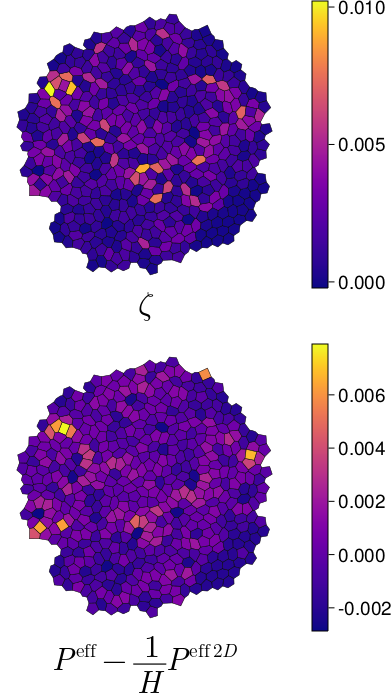

In [49]:
cellPolygons = makeCellPolygons(R,params,matrices)
ss2Dlims=(minimum((ss2D./h)), maximum((ss2D./h)))
ssZlims=(minimum((ssZ)), maximum((ssZ)))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=ss2D[i]/h,colormap=cgrad(:plasma, scale=log),colorrange=ss2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=ssZ[i],colormap=cgrad(:plasma, scale=log),colorrange=ssZlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=ss2Dlims,colormap=cgrad(:plasma, scale=log),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=ssZlims,colormap=cgrad(:plasma, scale=log),flipaxis=true)


Label(fig[1,1,Bottom()],string(L"\zeta"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"P^{\mathrm{eff}}-\frac{1}{H} P^{\mathrm{eff}\, 2D}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","Area_Perimeter.png"),fig)
#save(datadir(f,"plots","AL_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [408]:
minimum(ss2D./h)

-2.4258060579588743e-6

In [411]:
ss2D



500-element Vector{Float64}:
  2.9197013047031767e-9
 -2.8845424657212822e-9
  1.88427470544571e-9
  9.02147577315309e-9
  3.812178218462067e-6
  4.171673938754404e-9
  2.4475349261186146e-9
 -6.476084442263579e-9
  1.9761120860599685e-8
  1.6615711376758596e-8
  ⋮
  9.339768388856076e-9
  1.1651862665101139e-8
  2.2243440888232538e-8
  4.650741998915884e-8
 -2.708942920976342e-9
  6.546937106596305e-9
  1.4849109134944256e-7
  7.5130050045495e-9
  1.885821384311984e-8

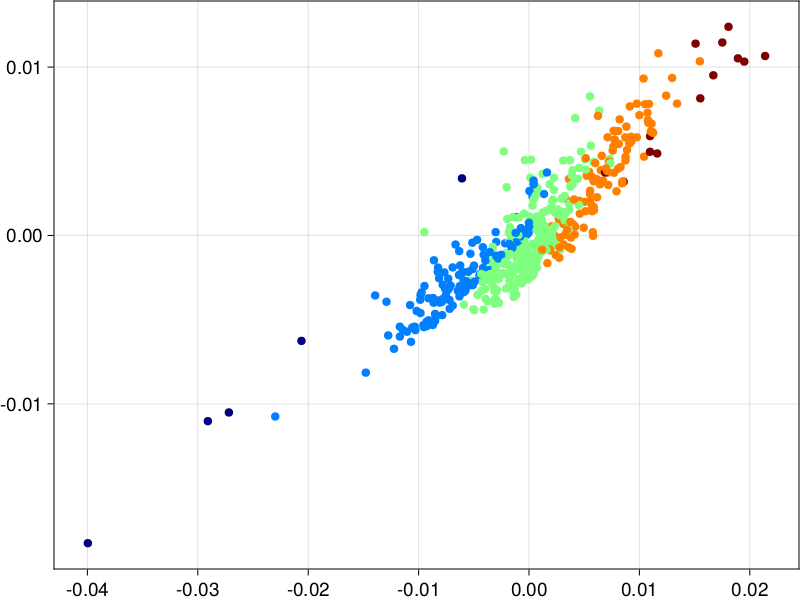

In [9]:
scatter(Peff2D, Peff3D, color=cellEdgeCount, colormap=:jet)


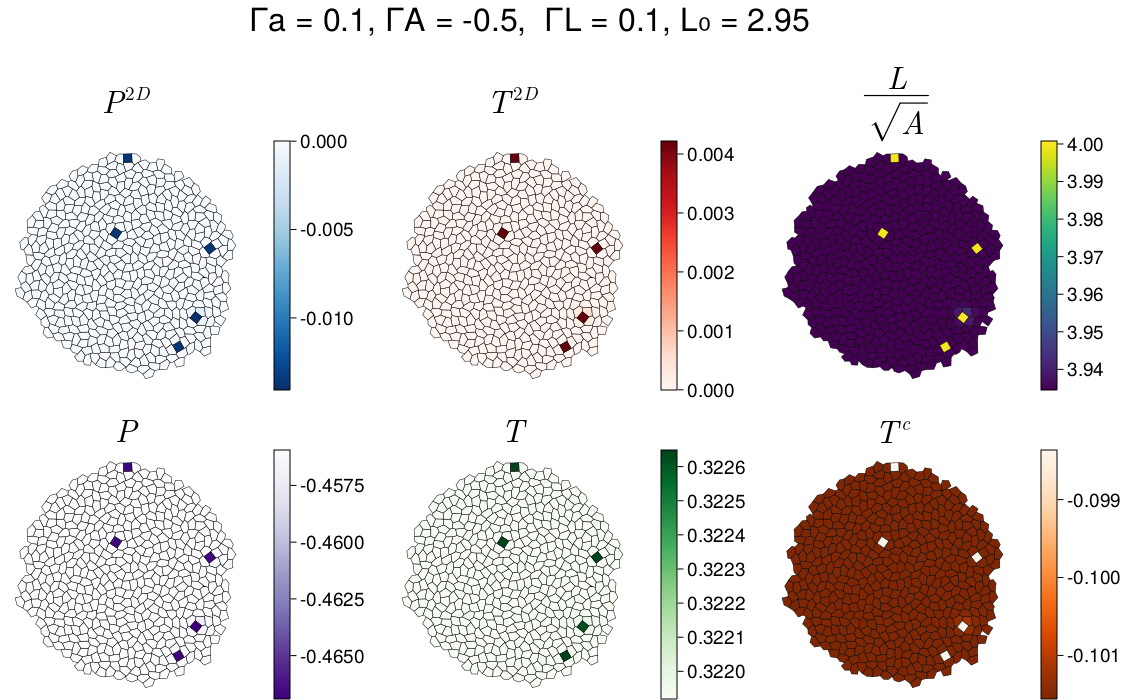

CairoMakie.Screen{IMAGE}


In [59]:
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
slims=(minimum(abs.(shapeParam2D[1:nCells])), maximum(abs.(shapeParam2D[1:nCells])))
#slims=(minimum(abs.(shapeParam2D[1:nCells])), 4.1)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(cellPressures[1:nCells]), maximum(cellPressures[1:nCells]))
Tlims=(minimum(cellTensions[1:nCells]), maximum(cellTensions[1:nCells]))

Phlims=(minimum(Ph), maximum(Ph))
Thlims=(minimum(Th), maximum(Th))
Thclims=(minimum(Thc), maximum(Thc))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
a15=Axis(fig[1,5],aspect=DataAspect())
a25=Axis(fig[2,5],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
hidedecorations!(a15)
hidespines!(a15)
hidedecorations!(a25)
hidespines!(a25)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=cellPressures[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=cellTensions[i],colormap=cgrad(:Reds_9),colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a15,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=slims, strokecolor=(:black,1.0),strokewidth=0.5)

    poly!(a21,cellPolygons[i],color=Ph[i],colormap=cgrad(:Purples_9, rev=true),colorrange=Phlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=Th[i],colormap=cgrad(:Greens_9),colorrange=Thlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a25,cellPolygons[i],color=Thc[i],colormap=cgrad(:Oranges_9, rev=true),colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))
colsize!(fig.layout,5,Aspect(1,1.0))



Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Tlims,colormap=:Reds_9,flipaxis=true)
Colorbar(fig[1,6],limits=colorrange=slims,colormap=:viridis,flipaxis=true)


Colorbar(fig[2,2],limits=colorrange=Phlims,colormap=cgrad(:Purples_9, rev=true),flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Thlims,colormap=cgrad(:Greens_9),flipaxis=true)
Colorbar(fig[2,6],limits=colorrange=Thclims,colormap=cgrad(:Oranges_9, rev=true),flipaxis=true)

Label(fig[1,1,Top()],L"P^{2D}",fontsize = 32, rotation=0)
Label(fig[1,3,Top()],L"T^{2D}",fontsize = 32, rotation=0)
Label(fig[1,5,Top()],L"\frac{L}{\sqrt{A}}",fontsize = 32, rotation=0)


Label(fig[2,1,Top()],L"P",fontsize = 32, rotation=0)
Label(fig[2,3,Top()],L"T",fontsize = 32, rotation=0)
Label(fig[2,5,Top()],L"T^{c}",fontsize = 32, rotation=0)

#Label( fig[0,:],L"\Gamma_a = "*string(params.Γa)*L", \Gamma_A = "*string(params.ΓA)*L", \Gamma_L = "*string(params.ΓL)*L", L_0 = "*string(params.L₀),fontsize = 32, color = (:black, 1))

Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","PT_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

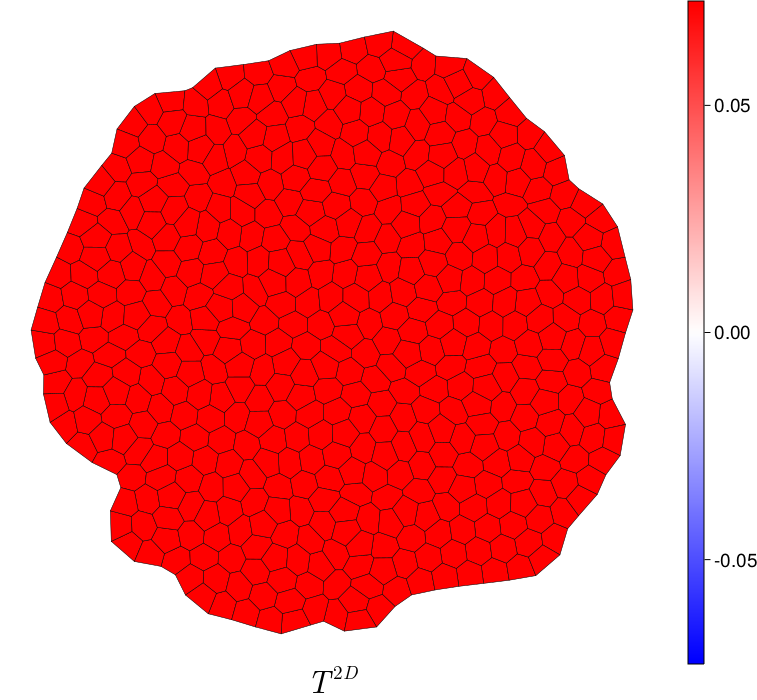

In [278]:
#Peff3D=Ph .+((2/3) .*(Th.+(ΓA/2)).*(cellPerimeters./cellAreas)) .+ ((1/3).*Thc.*(cellPerimeters./(cellHeights.*cellAreas)))

cellPolygons = makeCellPolygons(R,params,matrices)
Pefflims=(-(abs.(minimum(cellTensions)))), (abs.(minimum(cellTensions)))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())

hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellTensions[i],colormap=:bwr,colorrange=Pefflims, strokecolor=(:black,1.0),strokewidth=0.5)

end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Pefflims,colormap=:bwr,flipaxis=true)

Label(fig[1,1,Bottom()],string(L"T^{2D}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","Area_Perimeter.png"),fig)
fig

In [9]:
Peff3D

500-element Vector{Float64}:
  0.04935241512678773
  0.0425113854728547
 -0.03931754307401976
 -0.00296197725428775
  0.08179541042248113
 -0.0038207321275961457
  0.06761834104748823
  0.06405031189908039
 -0.003036960304582995
 -0.010479665760202587
  ⋮
 -0.06926041143071146
 -0.05981526355537875
  0.012462844605395963
 -0.06747527576989737
 -0.07190243828223716
 -0.00761038149311974
 -0.1282517929290943
  0.01672540042767414
 -0.042482810981743516

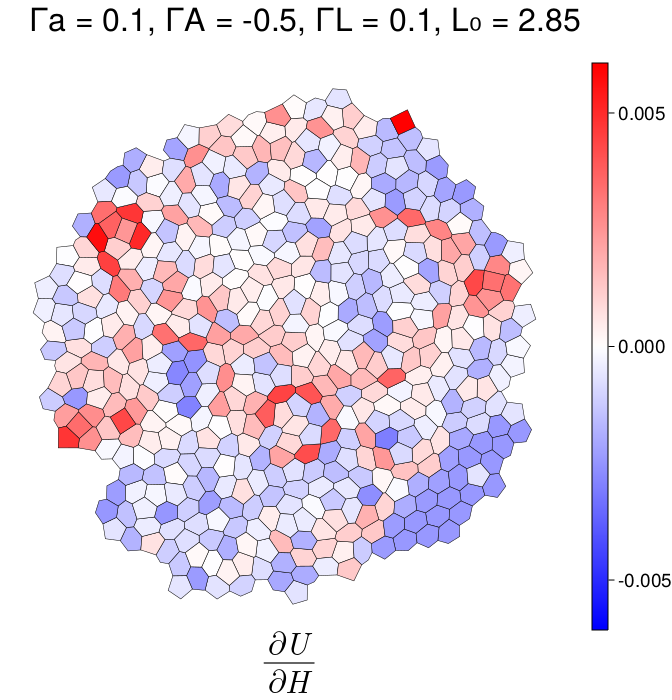

In [102]:
#Peff3D=Ph .+ (2/3).*Th.*(2.0.*cellAreas.+h.*cellPerimeters)./cellVolumes .+ (1/3).*ΓA.*(h.*cellPerimeters)./cellVolumes .+ Thc.*cellPerimeters./cellVolumes

cellPolygons = makeCellPolygons(R,params,matrices)
Fzlims=(-maximum(abs.(Fz)), maximum(abs.(Fz)))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())

hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i],color=Fz[i],colormap=:bwr,colorrange=Fzlims, strokecolor=(:black,1.0),strokewidth=0.5)

end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Fzlims,colormap=:bwr,flipaxis=true)

Label(fig[1,1,Bottom()],string(L"\frac{\partial U}{\partial H}"),fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","dUdH_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

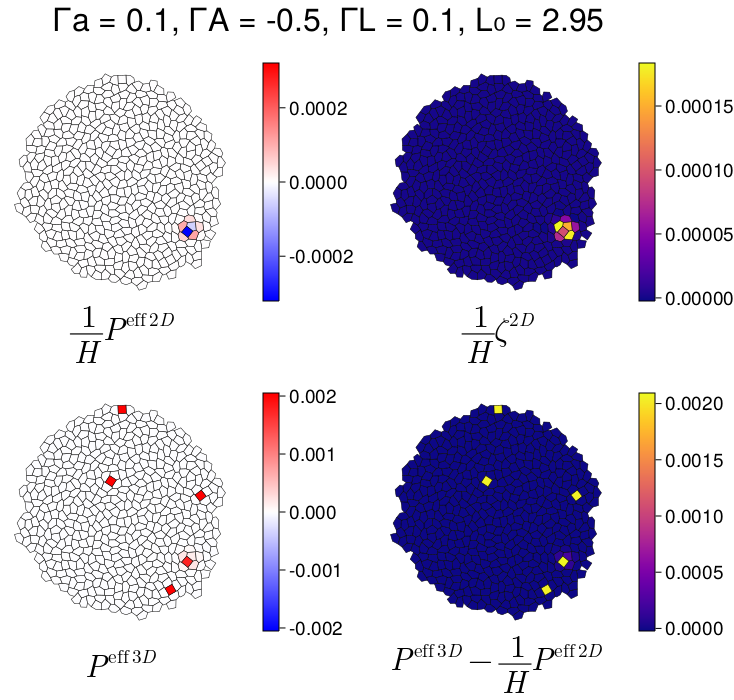

CairoMakie.Screen{IMAGE}


In [62]:


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Pe2Dlims=(-maximum(abs.(Peff2D./h)), maximum(abs.(Peff2D./h)))
Pe3Dlims=(-maximum(abs.(Peff3D)), maximum(abs.(Peff3D)))
delPefflims=(minimum(Peff3D.-(Peff2D./h)), maximum(Peff3D.-(Peff2D./h)))
zeta2Dlims=(minimum(ss2D./h), maximum(ss2D./h))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=(Peff2D./h)[i],colormap=:bwr,colorrange=Pe2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=Peff3D[i],colormap=:bwr,colorrange=Pe3Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=(ss2D./h)[i],colormap=:plasma,colorrange=zeta2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=(Peff3D.-(Peff2D./h))[i],colormap=:plasma,colorrange=delPefflims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))

Colorbar(fig[1,2],limits=Pe2Dlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,2],limits=Pe3Dlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[1,4],limits=zeta2Dlims,colormap=:plasma,flipaxis=true)
Colorbar(fig[2,4],limits=delPefflims,colormap=:plasma,flipaxis=true)

Label(fig[1,1,Bottom()],L"\frac{1}{H}P^{\mathrm{eff}\,2D}",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],L"P^{\mathrm{eff}\,3D}",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],L"\frac{1}{H}\zeta^{2D}",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],L"P^{\mathrm{eff}\,3D}-\frac{1}{H} P^{\mathrm{eff}\,2D}",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","stress_Peff_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

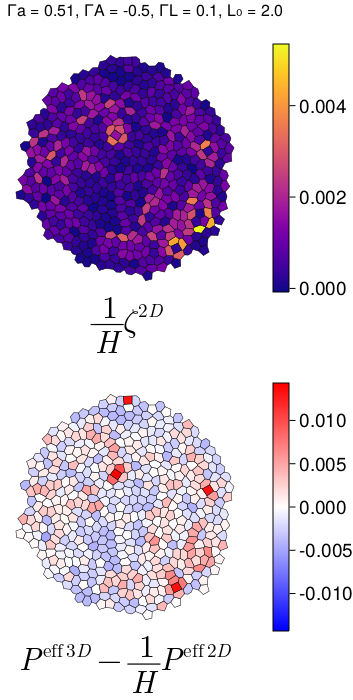

CairoMakie.Screen{IMAGE}


In [21]:
cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices

delPefflims=(-maximum(abs.(Peff3D.-(Peff2D./h))), maximum(abs.(Peff3D.-(Peff2D./h))))
zeta2Dlims=(minimum(ss2D./h), maximum(ss2D./h))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())

hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)

for i=1:nCells

    poly!(a11,cellPolygons[i],color=(ss2D./h)[i],colormap=:plasma,colorrange=zeta2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=(Peff3D.-(Peff2D./h))[i],colormap=:bwr,colorrange=delPefflims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))



Colorbar(fig[1,2],limits=zeta2Dlims,colormap=:plasma,flipaxis=true)
Colorbar(fig[2,2],limits=delPefflims,colormap=:bwr,flipaxis=true)



Label(fig[1,1,Bottom()],L"\frac{1}{H}\zeta^{2D}",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],L"P^{\mathrm{eff}\,3D}-\frac{1}{H} P^{\mathrm{eff}\,2D}",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 16, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"plots","shear_stress_Peff_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

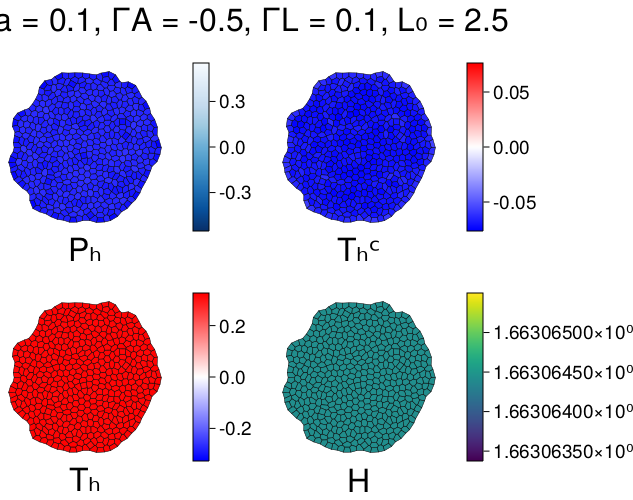

CairoMakie.Screen{IMAGE}


In [609]:
h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(-maximum(abs.(Ph)), maximum(abs.(Ph)))
Tlims=(-maximum(abs.(Th)), maximum(abs.(Th)))
Thclims=(-maximum(abs.(Thc)), maximum(abs.(Thc)))
Hlims=(minimum(cellHeights[1:nCells])-1e-6, maximum(cellHeights[1:nCells])+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=Ph[i],colormap=:bwr,colorrange=Plims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=Th[i],colormap=:bwr,colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=Thc[i],colormap=:bwr,colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=cellHeights[i],colormap=:viridis,colorrange=Hlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Thclims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Hlims,colormap=:viridis,flipaxis=true)

Label(fig[1,1,Bottom()],"Pₕ",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tₕ",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Tₕᶜ",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"H",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","pressure_tension_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

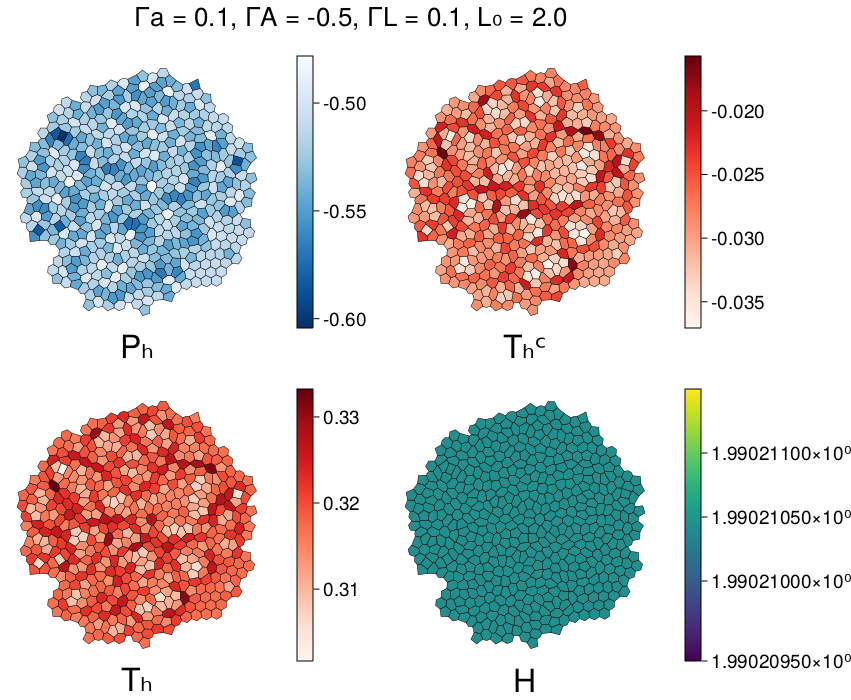

CairoMakie.Screen{IMAGE}


In [291]:
h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(Ph)-1e-6, maximum(Ph)+1e-6)
Tlims=(minimum(Th)-1e-6, maximum(Th)+1e-6)
Thclims=(minimum(Thc)-1e-6, maximum(Thc)+1e-6)
Hlims=(minimum(cellHeights[1:nCells])-1e-6, maximum(cellHeights[1:nCells])+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=Ph[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=Th[i],colormap=cgrad(:Reds_9),colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=Thc[i],colormap=cgrad(:Reds_9),colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=cellHeights[i],colormap=:viridis,colorrange=Hlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Thclims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Hlims,colormap=:viridis,flipaxis=true)

Label(fig[1,1,Bottom()],"Pₕ",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tₕ",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Tₕᶜ",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"H",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 26, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","pressure_tension_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*"_b_r.png"),fig)

display(fig)

In [ ]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
cellPolygons = makeCellPolygons(R,params,matrices)
Vlims=(minimum(abs.(cellVolumes[1:nCells])), maximum(abs.(cellVolumes[1:nCells])))
alims=(minimum(abs.(cellSurface[1:nCells])), maximum(abs.(cellSurface[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellVolumes[i],colormap=:viridis,colorrange=Vlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=cellSurface[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Vlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"Volume"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"Surface Area"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","vol_sa.png"),fig)
fig

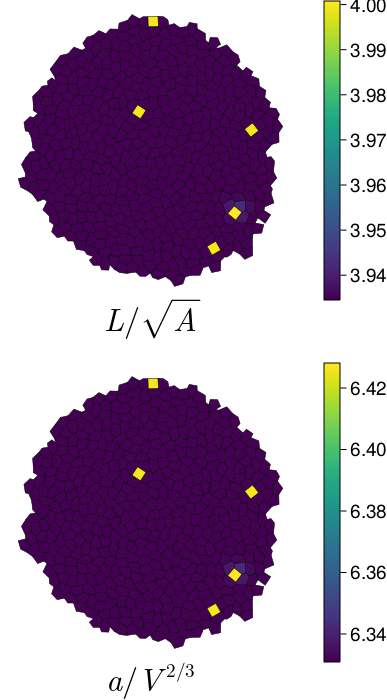

In [431]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
shapeParam3D=cellSurface./(cellVolumes.^(2/3))
cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells])), maximum(abs.(shapeParam2D[1:nCells])))
blims=(minimum(abs.(shapeParam3D[1:nCells])), maximum(abs.(shapeParam3D[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=shapeParam3D[i],colormap=:viridis,colorrange=blims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=blims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"a/V^{2/3}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","shapeparam.png"),fig)
fig

In [44]:
SPlims=(3.745940209994778, 4.015960215607112)
zetalims=(-0.00022820593659707525, 0.010021881584718157)
zlims=(-0.0022971225699312133, 0.007562873863541717)
Tlims=(-0.000969274810993806, 0.015733121835473318)


(-0.000969274810993806, 0.015733121835473318)

In [ ]:


zetalims=(-2.8088193412264418e-5, 0.004629445266021748)
zlims=(-0.005739920228801683,0.005739920228801683)

(minimum(ss2D./h), maximum(ss2D./h))

(-2.8088193412264418e-5, 0.004629445266021748)

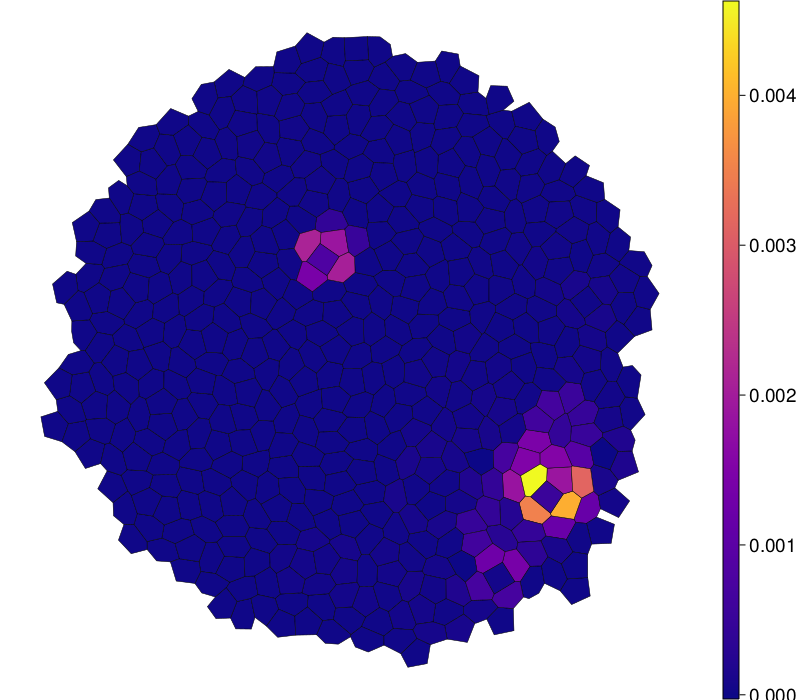

CairoMakie.Screen{IMAGE}


In [60]:
cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices


zetalims=(-2.8088193412264418e-5, 0.004629445266021748)
zlims=(-0.005739920228801683,0.005739920228801683)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Arial", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())

hidedecorations!(a11)
hidespines!(a11)


for i=1:nCells

    poly!(a11,cellPolygons[i],color=(ss2D./h)[i],colormap=cgrad(:plasma, scale=Makie.pseudolog10),colorrange=zetalims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))



Colorbar(fig[1,2],limits=zetalims,colormap=cgrad(:plasma, scale=Makie.pseudolog10),flipaxis=true)

#Label(fig[1,1,Bottom()],L"shapeParam2D",fontsize = 32, rotation=0)
#Label(fig[2,1,Bottom()],L"Tension",fontsize = 32, rotation=0)


#Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"plots","shear_plane_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".eps"),fig)

display(fig)



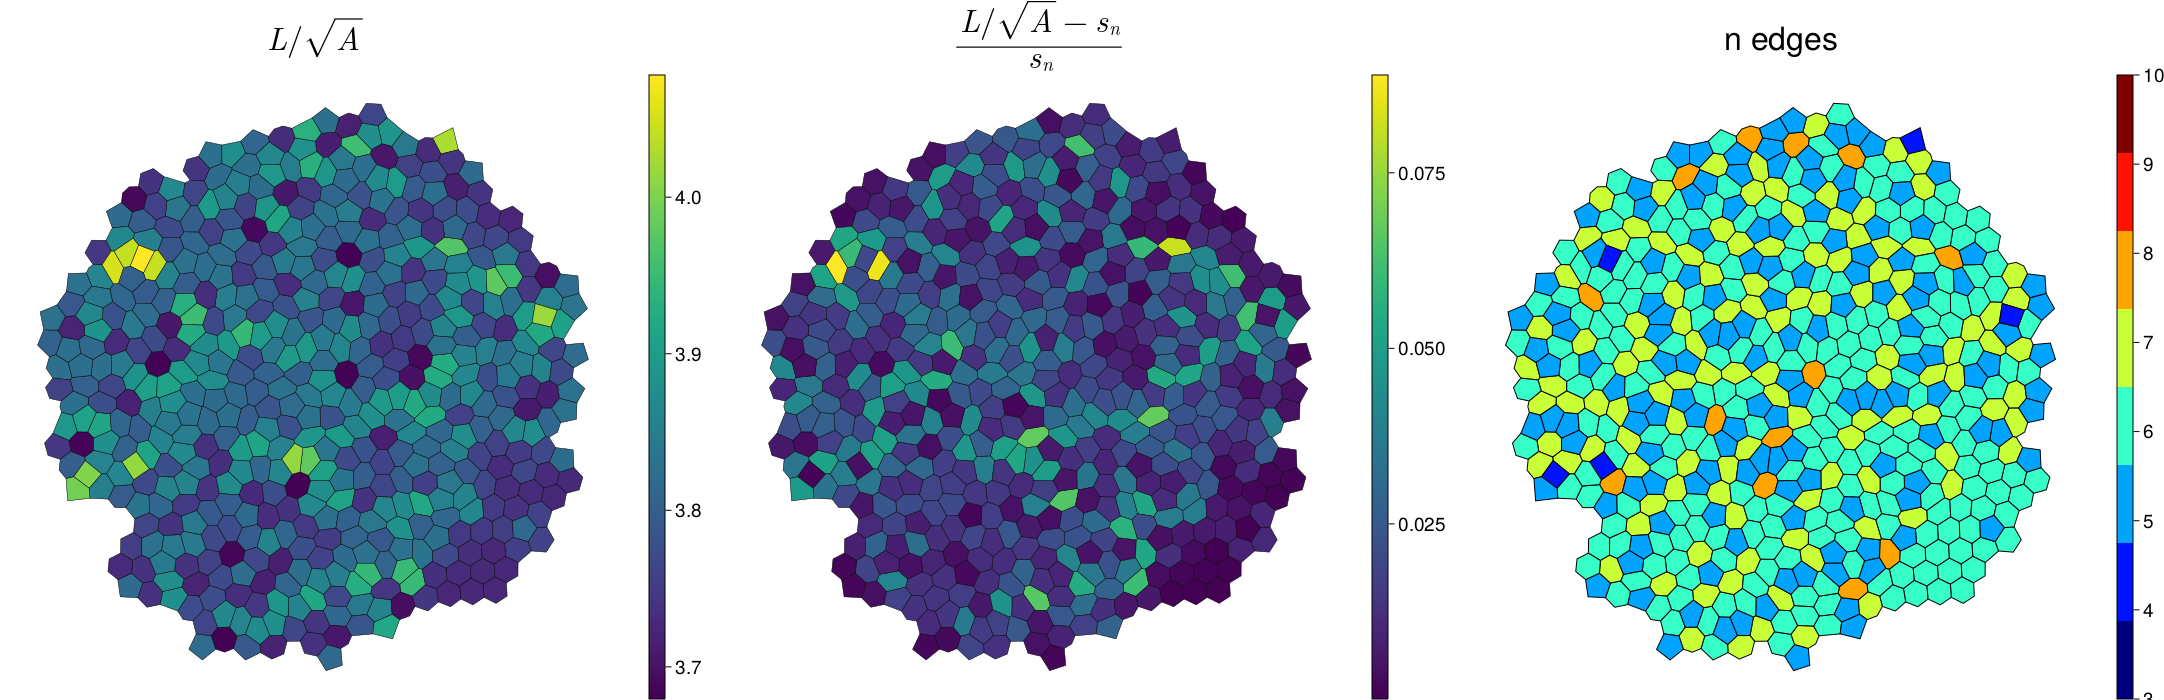

In [293]:

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))

cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells]))-1e-6, maximum(abs.(shapeParam2D[1:nCells]))+1e-6)
blims=(minimum(abs.(spdiff[1:nCells]))-1e-6, maximum(abs.(spdiff[1:nCells]))+1e-6)
clims=(minimum(abs.(spdiff_norm[1:nCells]))-1e-6, maximum(abs.(spdiff_norm[1:nCells]))+1e-6)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[1,3],aspect=DataAspect())
a3=Axis(fig[1,5],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
hidedecorations!(a3)
hidespines!(a3)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
    #poly!(a2,cellPolygons[i],color=spdiff[i],colormap=:viridis,colorrange=blims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=spdiff_norm[i],colormap=:viridis,colorrange=clims, strokecolor=(:black,1.0),strokewidth=0.5)

    poly!(a3,cellPolygons[i], color=cellEdgeCount[i], colorrange=(3, 10),colormap=cgrad(ColorSchemes.jet, 8, categorical=true),strokecolor=:black, strokewidth=1)

end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))
colsize!(fig.layout,3,Aspect(1,1.0))
colsize!(fig.layout,5,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)
#Colorbar(fig[1,4],limits=colorrange=blims,colormap=:viridis,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=clims,colormap=:viridis,flipaxis=true)

Colorbar(fig[1,6],limits=(3,10),colormap=cgrad(ColorSchemes.jet, 8, categorical=true),flipaxis=true)


Label(fig[1,1,Top()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
#Label(fig[1,3,Top()],string(L"L/\sqrt{A}-s_n"),fontsize = 32, rotation=0)
Label(fig[1,3,Top()],string(L"\frac{L/\sqrt{A}-s_n}{s_n}"),fontsize = 32, rotation=0)

Label(fig[1,5,Top()],string("n edges"),fontsize = 32, rotation=0)

#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","shapeparam_norm.png"),fig)
fig

In [ ]:
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="s")


violin!(ax,cellEdgeCount, shapeParam2D, show_median=true, datalimits=extrema)
scatter!(ax,[4,5,6,7,8], scrit[1:5], color=:red)

fig

In [ ]:
hist(cellEdgeCount)

In [ ]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount, shapeParam2D;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "s",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
save(datadir(f,"plots","shapeparam_distribution.png"),fig)
fig

In [ ]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount[cellsI.>0], shapeParam2D[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "s",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","shapeparam_internal_distribution.png"),fig)
fig

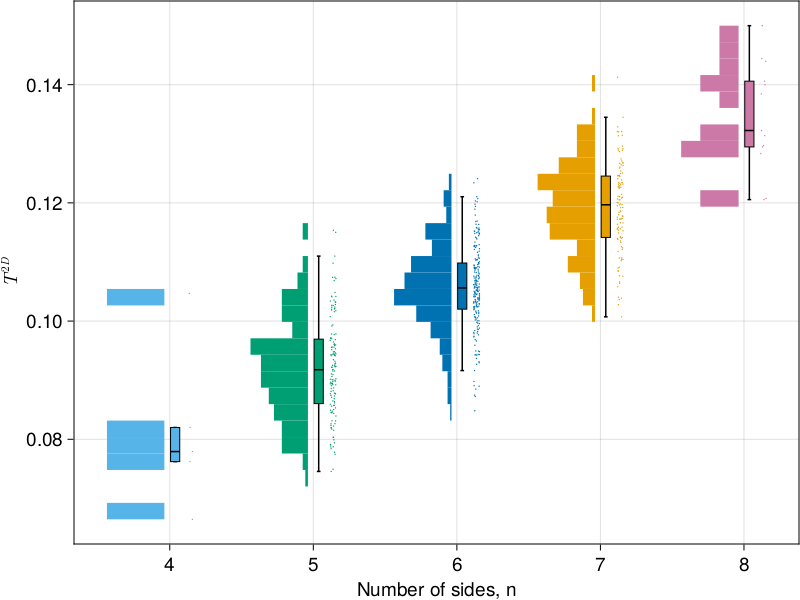

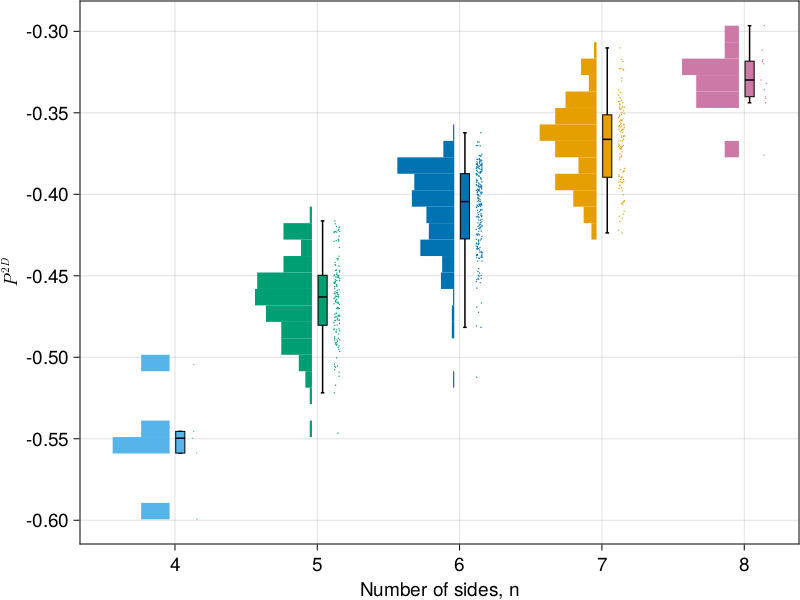

In [295]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount, cellTensions;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = L"T^{2D}",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
#save(datadir(f,"plots","T2D_distribution.png"),fig)
display(fig)


colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount, cellPressures;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = L"P^{2D}",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
#save(datadir(f,"plots","P2D_distribution.png"),fig)
fig

In [ ]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount[cellsI.>0], cellTensions[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = L"T^{2D}",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","T2D_internal_distribution.png"),fig)
display(fig)


colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount[cellsI.>0], cellPressures[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = L"P^{2D}",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","P2D_internal_distribution.png"),fig)
fig


In [ ]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount, Th;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "Surface area tension, T",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
save(datadir(f,"plots","T_distribution.png"),fig)
display(fig)

fig=rainclouds(cellEdgeCount, Thc;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "line tension, Tc ",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
save(datadir(f,"plots","Tc_distribution.png"),fig)
display(fig)

fig=rainclouds(cellEdgeCount, Ph;
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "3D pressure,  P",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount, unique(cellEdgeCount))])
save(datadir(f,"plots","P3D_distribution.png"),fig)
fig

In [ ]:

colors = Makie.wong_colors()

fig=rainclouds(cellEdgeCount[cellsI.>0], Th[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "Surface area tension, T",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","T_internal_distribution.png"),fig)
display(fig)

fig=rainclouds(cellEdgeCount[cellsI.>0], Thc[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "line tension, Tc ",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","Tc_internal_distribution.png"),fig)
display(fig)

fig=rainclouds(cellEdgeCount[cellsI.>0], Ph[cellsI.>0];
    axis = (;
        xlabel = "Number of sides, n",
        ylabel = "3D pressure,  P",
        title = ""
    ),
    plot_boxplots = true, cloud_width=0.5, clouds=hist,
    color = colors[indexin(cellEdgeCount[cellsI.>0], unique(cellEdgeCount[cellsI.>0]))])
save(datadir(f,"eigenmodes","P3D_internal_distribution.png"),fig)
fig

In [ ]:
dAdr=-1/2*B*Diagonal([(ϵ*T) for T in edgeTangents])*Ā
#dLdr=Sum j B̄ᵢⱼ Aⱼₖ t̂ⱼ   = B̄ diag(t̂) A
dLdr= B̄*Diagonal((edgeTangents)./norm.(edgeTangents))*A

Mtemp=vcat(dAdr,dLdr)
Mflat=transpose(reshape(reinterpret(Float64,[vcat(Matrix(Mtemp)[x,:]...) for x in collect(1:2*nCells)]), ( 2*nVerts, 2*nCells)))

In [ ]:
MevHh=Mflat*evecHh[1:end-1, 1:end]
MevHinf=Mflat*evecHinf[1:end-1, 1:end]

In [45]:
cellPolygons = makeCellPolygons(R,params,matrices)
   for k=1:2*nVerts+1    
        #Aevlims=(-maximum(abs.(MevHh[1:nCells, :])), maximum(abs.(MevHh[1:nCells, :])))
        #k=589
        #Aevlims=(-maximum(abs.(MevHh[1:nCells, k])), maximum(abs.(MevHh[1:nCells, k])))

        Aevlims=(-0.1,0.1)

        set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
        fig = Figure(resolution=(1500,500))

        a1=Axis(fig[1,1],aspect=DataAspect())
        hidedecorations!(a1)
        hidespines!(a1)

        for i=1:nCells
            poly!(a1,cellPolygons[i],color=MevHinf[1:nCells,k][i],colormap=:bwr,colorrange=Aevlims, strokecolor=(:grey,1.0),strokewidth=0.5)
        end

        colsize!(fig.layout,1,Aspect(1,1.0))
        Label(fig[1,1,Top()],"n = "*string(k),fontsize = 32)
        Label(fig[1,1,Bottom()],"ΔH = $(@sprintf("%2.2e",evecHinf[end,k]))",fontsize = 32)
        resize_to_layout!(fig)
        arrows!(a1, Point2f.(R),Vec2f.(reinterpret(SVector{2,Float64},evecHinf[1:end-1,k])), color=:black, arrowsize=7, lengthscale=0.5/maximum(abs.(evecHh[1:end-1,k])))
        mkpath(datadir(f,"eigenmodes", "vertex_modes"))
        save(datadir(f,"eigenmodes", "vertex_modes","Hinf_vertex_mode_$(@sprintf("%03d", k))_Area.png"),fig)
    end
#fig

In [ ]:
cellAreas

In [ ]:
mean(abs.(MevHh[1:nCells, end]))

In [ ]:
(cellAreas .+ (Γa.*(1 .- 2 .*cellAreas) .- 0.5 .* ΓA).*cellPerimeters)./(cellAreas.^2 .+ Γa.*cellPerimeters.^2)

In [ ]:
sum((cellAreas .+ (Γa.*(1 .- 2 .*cellAreas) .- 0.5 .* ΓA).*cellPerimeters))/sum((cellAreas.^2 .+ Γa.*cellPerimeters.^2))

In [ ]:
rand(1:420)

In [ ]:
edgesP=vec((abs.(ones(nCells)'*B)))
vertsP=vec((0.5.*edgesP'*abs.(A))')
edgesB=vec(abs.(A*(ones(nVerts).-vertsP)))
edgesI=vec(ones(nEdges).-edgesB.-edgesP)

rand_edge=rand(findall(x->x!=0, edgesI))
edgev=findall(x->x!=0,A[rand_edge, :])

anew=(R[edgev[1]]-matrices.edgeMidpoints[rand_edge])*0.02 +matrices.edgeMidpoints[rand_edge]
bnew=(R[edgev[2]]-matrices.edgeMidpoints[rand_edge])*0.02 +matrices.edgeMidpoints[rand_edge]

In [ ]:
R[edgev[1]]=anew
R[edgev[2]]=bnew


cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells]))-1e-6, maximum(abs.(shapeParam2D[1:nCells]))+1e-6)
blims=(minimum(abs.(shapeParam3D[1:nCells]))-1e-6, maximum(abs.(shapeParam3D[1:nCells]))+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
fig

In [169]:
eigvals(Matrix(B*B'))

500-element Vector{Float64}:
 0.058055727171295264
 0.15007563122968248
 0.1554626716409364
 0.26868127791548946
 0.2823762366924241
 0.30069834793538747
 0.4179599264507121
 0.4237286099504601
 0.4666387262940563
 0.48507002358456797
 ⋮
 9.645176565388196
 9.722387190786556
 9.735834381980428
 9.753225816824582
 9.763372626062342
 9.788006394935834
 9.802446935433585
 9.847007113263095
 9.875901848267324

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
500-element Vector{Float64}:
 -3.552713678800501e-15
  0.036039947784457974
  0.0393663595764647
  0.09911526208272484
  0.10372190127182994
  0.15142496702891606
  0.1791280512226674
  0.19574841184454783
  0.27613915246855036
  0.2932259371775654
  ⋮
  9.440162852593694
  9.622454460494762
  9.721083930069264
  9.734035700645272
  9.751135746229448
  9.75796635824291
  9.785589206448563
  9.815828248217054
  9.875019718525872
vectors:
500×500 Matrix{Float64}:
 -0.0447214   0.0750749    0.00388597   …  -0.000314492  -0.000428099
 -0.0447214   0.0271028   -0.0186819        0.0721069     0.260419
 -0.0447214  -0.0575755    0.0479236       -5.02168e-7    1.89498e-7
 -0.0447214  -0.0732765   -0.00809653      -9.08353e-5    5.21068e-5
 -0.0447214   0.0674043   -0.0365846        0.0089146     0.00525511
 -0.0447214   0.076598    -0.000233916  …  -2.80186e-5   -3.90398e-5
 -0.0447214  -0.0375884   -0.0646739       -0.00191782 

In [22]:
evals, evecs=eigen(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))
L=svd(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))
Lp=L.V*Diagonal(vcat([1/s for s in L.S[1:end-1]],0))*L.U'
Lp2=pinv(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))

H1=-Lp*Fz

H12=-Lp2*Fz

Sigp=Diagonal(vcat([1/s for s in L.S[1:end-1]],0))

500×500 Diagonal{Float64, Vector{Float64}}:
 0.101267   ⋅         ⋅         ⋅        …   ⋅         ⋅        ⋅       ⋅ 
  ⋅        0.101799   ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅        0.102196   ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅        0.102473      ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅        …   ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
 ⋮                                       ⋱                             
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        ⋅       ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅   

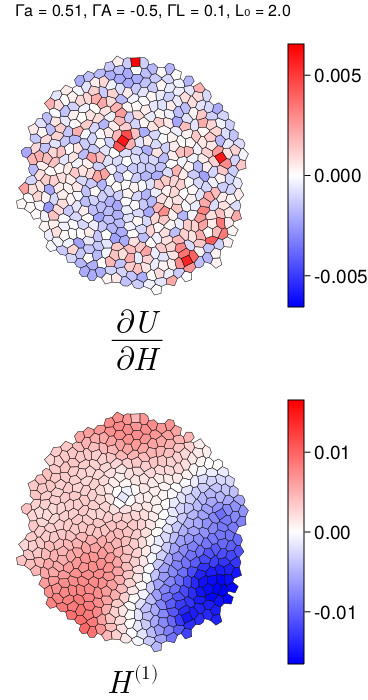

In [23]:
#Peff3D=Ph .+ (2/3).*Th.*(2.0.*cellAreas.+h.*cellPerimeters)./cellVolumes .+ (1/3).*ΓA.*(h.*cellPerimeters)./cellVolumes .+ Thc.*cellPerimeters./cellVolumes

cellPolygons = makeCellPolygons(R,params,matrices)
H1lims=(-maximum(abs.(H1)), maximum(abs.(H1)))
Fzlims=(-maximum(abs.(Fz))), maximum(abs.(Fz))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a2)
hidespines!(a2)


for i=1:nCells
    poly!(a2,cellPolygons[i],color=H1[i],colormap=:bwr,colorrange=H1lims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a1,cellPolygons[i],color=Fz[i],colormap=:bwr,colorrange=Fzlims, strokecolor=(:black,1.0),strokewidth=0.5)


end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[2,2],limits=colorrange=H1lims,colormap=:bwr,flipaxis=true)
Colorbar(fig[1,2],limits=colorrange=Fzlims,colormap=:bwr,flipaxis=true)

Label(fig[2,1,Bottom()],string(L"H^{(1)}"),fontsize = 32, rotation=0)
Label(fig[1,1,Bottom()],string(L"\frac{\partial U}{\partial H}"),fontsize = 32, rotation=0)

Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 16, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","dUdH_H1_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

In [257]:
((diag(Sigp)[1:end-1].*(L.U'Fz)[1:end-1])'*L.U'[1:end-1, :])'-H1

500-element Vector{Float64}:
 7.346553920761778e-16
 7.940696711283834e-16
 7.4593109467002705e-16
 8.170547571850761e-16
 8.144526719711109e-16
 6.574601973952099e-16
 7.806255641895632e-16
 6.704706234650359e-16
 6.349087922075114e-16
 7.216449660063518e-16
 ⋮
 6.140921104957897e-16
 6.539907504432563e-16
 6.661338147750939e-16
 5.828670879282072e-16
 7.424616477180734e-16
 7.8236028766554e-16
 6.305719835175694e-16
 7.632783294297951e-16
 7.615436059538183e-16

H1

In [647]:
cellAdj=-(B*B'-Diagonal(cellEdgeCount))
SimpleDiGraph(cellAdj)

{500, 2836} directed simple Int64 graph

In [648]:
shell_matrix=floyd_warshall_shortest_paths(SimpleDiGraph(cellAdj))
dist_matrix=shell_matrix.dists

500×500 Matrix{Int64}:
  0   8  21  22   6   1  18  20  11  …  10  12  18   2   9  17  15   8  18
  8   0  15  14   8   8  10  14   7      4   8  15   8   3   9   7   1  10
 21  15   0   8  23  22  16   1  20     12   9   6  20  18  13  10  16  10
 22  14   8   0  20  22  10   8  16     13  12  13  21  15   7   7  14   5
  6   8  23  20   0   6  14  22   6     12  14  20   7   6  14  15   7  16
  1   8  22  22   6   0  18  21  11  …  11  13  19   3   9  17  15   8  18
 18  10  16  10  14  18   0  15   9     14  15  20  18  10   3  10  10   6
 20  14   1   8  22  21  15   0  19     11   8   5  19  17  12   9  15   9
 11   7  20  16   6  11   9  19   0     11  15  21  12   5  10  12   7  12
  9  12  17  20  14  10  22  16  18     10   9  11   8  14  20  15  12  18
  ⋮                   ⋮              ⋱                   ⋮              
 10   4  12  13  12  11  14  11  11      0   4  11   9   7  11   7   5  10
 12   8   9  12  14  13  15   8  15      4   0   8  11  11  12   7   9  10
 18 

In [649]:
D6=dist_matrix[findall(x->x==6, cellEdgeCount),findall(x->x==6, cellEdgeCount)]
D5=dist_matrix[findall(x->x==5, cellEdgeCount),findall(x->x==5, cellEdgeCount)]
D7=dist_matrix[findall(x->x==7, cellEdgeCount),findall(x->x==7, cellEdgeCount)]

111×111 Matrix{Int64}:
  0  14   5  11  11  11   8  13   5  …   2   7   7   8   3   9   6   9  14
 14   0  12  14  15   9  19  12  10     16  20  10  22  12  16  20  19   6
  5  12   0   7  15   7   7  16   6      7  12   3  10   6  14   9  14  16
 11  14   7   0  21   5   8  22  12     13  18   6  13  13  20  13  20  20
 11  15  15  21   0  18  19   3   9     10  10  15  16   9   3  14   7   9
 11   9   7   5  18   0  11  18  10  …  13  18   4  15  11  18  14  20  15
  8  19   7   8  19  11   0  21  11     10  13   9   6  11  17   7  16  22
 13  12  16  22   3  18  21   0  10     13  13  16  19  10   6  17  10   6
  5  10   6  12   9  10  11  10   0      7  11   6  13   2   9  11  11  11
  6  20   9  15  12  15   9  15  11      4   4  12   5   9  10   2   7  18
  ⋮                   ⋮              ⋱               ⋮                   ⋮
  2  16   7  13  10  13  10  13   7      0   5   9   6   5   8   4   8  15
  7  20  12  18  10  18  13  13  11      5   0  14   8   9   8   6   3  17
  

In [650]:
sd=[0.5*length(findall(x->x==n, [(dist_matrix...)...])) for n in 1:maximum(dist_matrix)]
cd6=[0.5*length(findall(x->x==n, [(D6...)...])) for n in 1:maximum(dist_matrix)]
cd5=[0.5*length(findall(x->x==n, [(D5...)...])) for n in 1:maximum(dist_matrix)]
cd7=[0.5*length(findall(x->x==n, [(D7...)...])) for n in 1:maximum(dist_matrix)]

25-element Vector{Float64}:
  62.0
 163.0
 202.0
 287.0
 321.0
 364.0
 371.0
 414.0
 427.0
 405.0
   ⋮
 251.0
 213.0
 164.0
 119.0
  84.0
  45.0
  13.0
   5.0
   1.0

In [651]:
Ecd6=(sum(x->x==6, cellEdgeCount)/500)*((sum(x->x==6, cellEdgeCount)-1)/(500-1))*sd
Ecd5=(sum(x->x==5, cellEdgeCount)/500)*((sum(x->x==5, cellEdgeCount)-1)/(500-1))*sd
Ecd7=(sum(x->x==7, cellEdgeCount)/500)*((sum(x->x==7, cellEdgeCount)-1)/(500-1))*sd



25-element Vector{Float64}:
  69.39390781563127
 138.68993987975952
 203.19006012024047
 261.8176352705411
 311.1470140280561
 353.2335871743487
 383.9176352705411
 405.8907414829659
 417.58689378757515
 420.91466933867736
   ⋮
 257.5600400801603
 216.06072144288575
 172.8485771543086
 129.58749498997994
  87.50092184368737
  49.23150300601202
  20.260280561122244
   4.942725450901803
   0.48937875751503

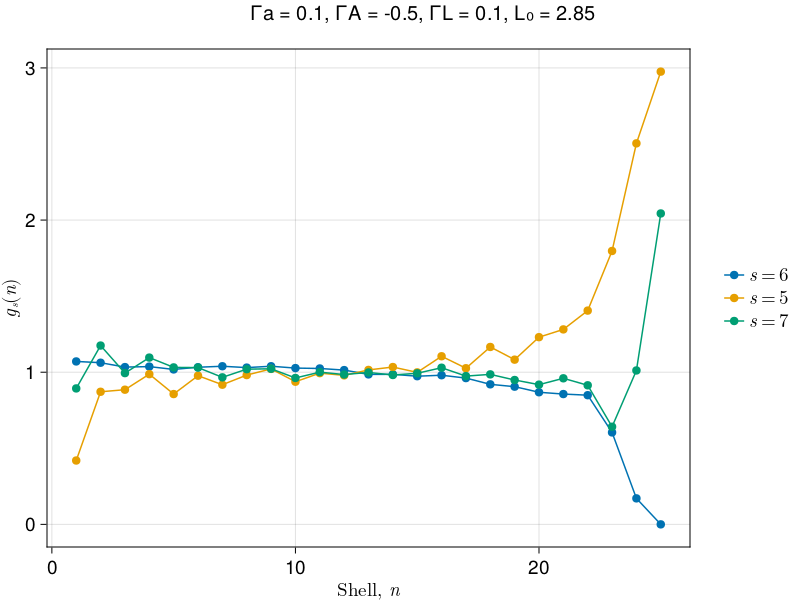

In [652]:
fig = Figure()
ax=Axis(fig[1, 1], xlabel=L"Shell, $n$", ylabel=L"$g_s(n)$")

scatterlines!(ax,1:maximum(dist_matrix),cd6./Ecd6,label=L"s=6")
scatterlines!(ax,1:maximum(dist_matrix),cd5./Ecd5,label=L"s=5")
scatterlines!(ax,1:maximum(dist_matrix),cd7./Ecd7,label=L"s=7")
fig[1, 2] = Legend(fig, ax, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize =20, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","correlation_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

In [653]:

D57=dist_matrix[findall(x->x==5, cellEdgeCount),findall(x->x==7, cellEdgeCount)]
D75=dist_matrix[findall(x->x==7, cellEdgeCount),findall(x->x==5, cellEdgeCount)]
cd57=[0.5*length(findall(x->x==n, [(D57...)...])) for n in 1:maximum(dist_matrix)]
cd75=[0.5*length(findall(x->x==n, [(D75...)...])) for n in 1:maximum(dist_matrix)]
Ecd57=(sum(x->(x==5), cellEdgeCount)/500)*((sum(x->(x==7), cellEdgeCount)-1)/(500-1))*sd
Ecd75=(sum(x->(x==7), cellEdgeCount)/500)*((sum(x->(x==5), cellEdgeCount)-1)/(500-1))*sd


D56=dist_matrix[findall(x->x==5, cellEdgeCount),findall(x->x==6, cellEdgeCount)]
D65=dist_matrix[findall(x->x==6, cellEdgeCount),findall(x->x==5, cellEdgeCount)]
cd56=[0.5*length(findall(x->x==n, [(D56...)...])) for n in 1:maximum(dist_matrix)]
cd65=[0.5*length(findall(x->x==n, [(D65...)...])) for n in 1:maximum(dist_matrix)]
D76=dist_matrix[findall(x->x==7, cellEdgeCount),findall(x->x==6, cellEdgeCount)]
D67=dist_matrix[findall(x->x==6, cellEdgeCount),findall(x->x==7, cellEdgeCount)]
cd76=[0.5*length(findall(x->x==n, [(D76...)...])) for n in 1:maximum(dist_matrix)]
cd67=[0.5*length(findall(x->x==n, [(D67...)...])) for n in 1:maximum(dist_matrix)]
Ecd56=(sum(x->(x==5), cellEdgeCount)/500)*((sum(x->(x==6), cellEdgeCount)-1)/(500-1))*sd
Ecd65=(sum(x->(x==6), cellEdgeCount)/500)*((sum(x->(x==5), cellEdgeCount)-1)/(500-1))*sd
Ecd76=(sum(x->(x==7), cellEdgeCount)/500)*((sum(x->(x==6), cellEdgeCount)-1)/(500-1))*sd
Ecd67=(sum(x->(x==6), cellEdgeCount)/500)*((sum(x->(x==7), cellEdgeCount)-1)/(500-1))*sd



25-element Vector{Float64}:
 150.6660521042084
 301.11959919839677
 441.1604008016032
 568.4509018036072
 675.5534268537074
 766.9305811623246
 833.5509018036072
 881.2582765531062
 906.6526252505009
 913.8777955911823
   ⋮
 559.2069338677354
 469.10480961923844
 375.28384769539076
 281.35663326653304
 189.97947895791583
 106.89002004008016
  43.9885370741483
  10.731503006012023
   1.0625250501002004

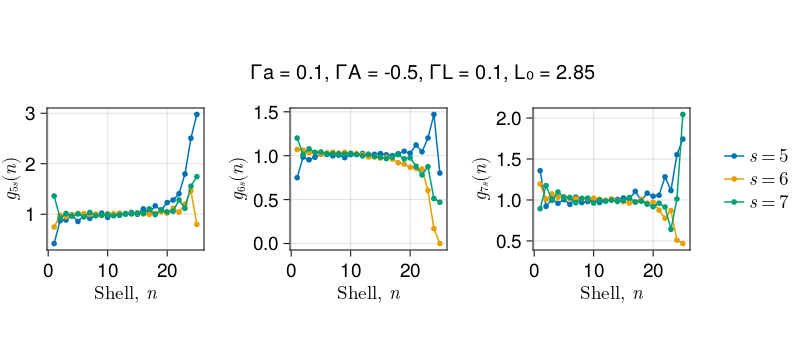

In [654]:
fig = Figure(size = (2000, 500))
ax5=Axis(fig[1, 1], xlabel=L"Shell, $n$", ylabel=L"$g_{5s}(n)$")

ax6=Axis(fig[1, 2], xlabel=L"Shell, $n$", ylabel=L"$g_{6s}(n)$")

ax7=Axis(fig[1, 3], xlabel=L"Shell, $n$", ylabel=L"$g_{7s}(n)$")

scatterlines!(ax5,1:maximum(dist_matrix),cd5./Ecd5,label=L"s=5", markersize=8)
scatterlines!(ax5,1:maximum(dist_matrix),cd56./Ecd56,label=L"s=6", markersize=8)
scatterlines!(ax5,1:maximum(dist_matrix),cd57./Ecd57,label=L"s=7", markersize=8)
#axislegend(ax5, position=:lt)

scatterlines!(ax6,1:maximum(dist_matrix),cd65./Ecd65,label=L"s=5", markersize=8)
scatterlines!(ax6,1:maximum(dist_matrix),cd6./Ecd6,label=L"s=6", markersize=8)
scatterlines!(ax6,1:maximum(dist_matrix),cd67./Ecd67,label=L"s=7", markersize=8)
#axislegend(ax6, position=:lb)

scatterlines!(ax7,1:maximum(dist_matrix),cd75./Ecd75,label=L"s=5", markersize=8)
scatterlines!(ax7,1:maximum(dist_matrix),cd76./Ecd76,label=L"s=6", markersize=8)
scatterlines!(ax7,1:maximum(dist_matrix),cd7./Ecd7,label=L"s=7", markersize=8)
#axislegend(ax7, position=:lb)
rowsize!(fig.layout,1,Relative(1/2))
fig[1, 4] = Legend(fig, ax6, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize =20, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","cross_correlation_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

In [633]:
Rad=norm.(cellPositions.-mean(cellPositions, dims=1))
callshell=[sum(x->x==n,dist_matrix[findall(x->x==minimum(Rad),Rad ),:]) for n in 1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:])]
c6shell=[sum(x->x==n,dist_matrix[findall(x->x==minimum(Rad),Rad ),:][findall(x->x==6,cellEdgeCount)]) for n in 1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:])]
c5shell=[sum(x->x==n,dist_matrix[findall(x->x==minimum(Rad),Rad ),:][findall(x->x==5,cellEdgeCount)]) for n in 1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:])]
c7shell=[sum(x->x==n,dist_matrix[findall(x->x==minimum(Rad),Rad ),:][findall(x->x==7,cellEdgeCount)]) for n in 1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:])]

13-element Vector{Int64}:
  1
  3
  3
  5
  7
  9
 12
 14
 14
 12
 20
  9
  2

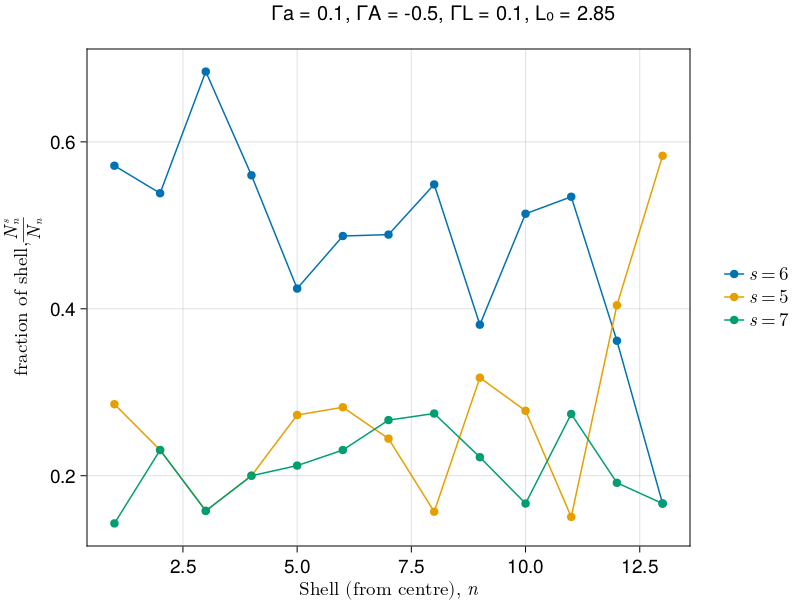

In [655]:
fig = Figure()
ax=Axis(fig[1, 1], xlabel=L"Shell (from centre), $n$", ylabel=L"fraction of shell,$\frac{N_n^s}{N_n}$")

scatterlines!(ax,1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:]),c6shell./callshell,label=L"s=6")
scatterlines!(ax,1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:]),c5shell./callshell,label=L"s=5")
scatterlines!(ax,1:maximum(dist_matrix[findall(x->x==minimum(Rad),Rad ),:]),c7shell./callshell,label=L"s=7")
fig[1, 2] = Legend(fig, ax, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize =20, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","radial_fraction_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

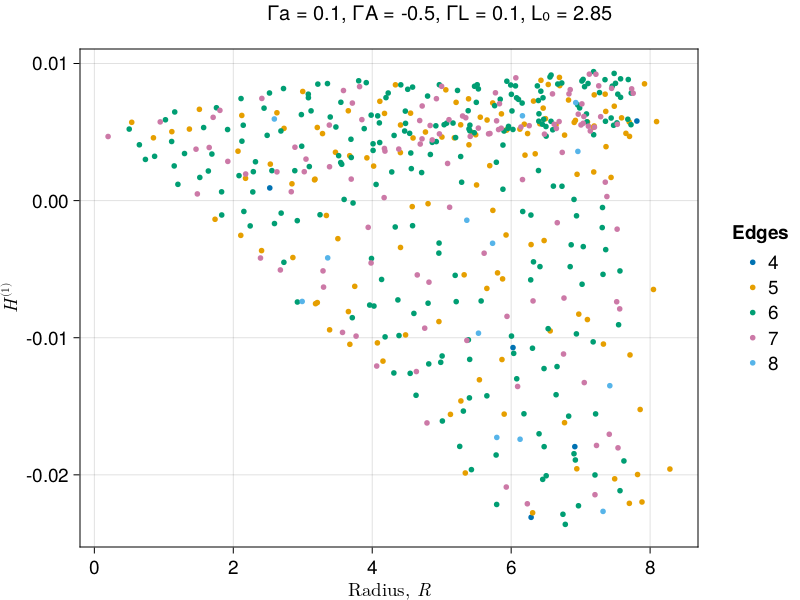

In [656]:
Rad=norm.(cellPositions.-mean(cellPositions, dims=1))
fig = Figure()
ax=Axis(fig[1, 1], xlabel=L"Radius, $R$", ylabel=L"$H^{(1)}$")
scatter!(Rad[cellEdgeCount.==4],H1[cellEdgeCount.==4] , markersize=8, label="4")
scatter!(Rad[cellEdgeCount.==5],H1[cellEdgeCount.==5] , markersize=8 , label="5")
scatter!(Rad[cellEdgeCount.==6],H1[cellEdgeCount.==6] , markersize=8, label="6")
scatter!(Rad[cellEdgeCount.==7],H1[cellEdgeCount.==7] , markersize=8, label="7")
scatter!(Rad[cellEdgeCount.==8],H1[cellEdgeCount.==8] , markersize=8, label="8")

fig[1, 2] = Legend(fig, ax, "Edges", framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize =20, color = (:black, 1))

save(datadir(f,"plots","H1_radius"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [27]:
fev="C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims/pseudo2D/500_cells/Final_config_Hfixed"

evH_3=readdlm(datadir(fev,"evalH_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_3.0.csv"))[:,1]
evLv_3=readdlm(datadir(fev,"evalLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_3.0.csv"))[:,1]
evmapLv_3=readdlm(datadir(fev,"evmapLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_3.0.csv"))[:,1]
evmapgX_3=readdlm(datadir(fev,"evmapgX_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_3.0.csv"))[:,1]

evH_29=readdlm(datadir(fev,"evalH_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.9.csv"))[:,1]
evLv_29=readdlm(datadir(fev,"evalLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.9.csv"))[:,1]
evmapLv_29=readdlm(datadir(fev,"evmapLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.9.csv"))[:,1]
evmapgX_29=readdlm(datadir(fev,"evmapgX_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.9.csv"))[:,1]


evH_285=readdlm(datadir(fev,"evalH_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.85.csv"))[:,1]
evLv_285=readdlm(datadir(fev,"evalLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.85.csv"))[:,1]
evmapLv_285=readdlm(datadir(fev,"evmapLv_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.85.csv"))[:,1]
evmapgX_285=readdlm(datadir(fev,"evmapgX_Γa_0.1_ΓA_-0.5_ΓL_0.1_L0_2.85.csv"))[:,1]

2160-element Vector{Float64}:
 -2.4663609051235044e-6
 -2.486433437618205e-7
 -2.433330864250741e-18
 -5.86409169301705e-18
  5.005911225983405e-7
  1.9421282298301247e-6
  1.9816130493218607e-6
  3.127156325963123e-6
  1.7457661353177605e-5
  2.7652492832893038e-5
  ⋮
 -0.010191063783681701
 -0.006821908542865436
 -0.010260313737097501
 -0.01148980285211253
 -0.008172756308739815
 -0.013964145119480164
 -0.008923320479448717
 -0.011556211533972982
 -0.01439929782077563

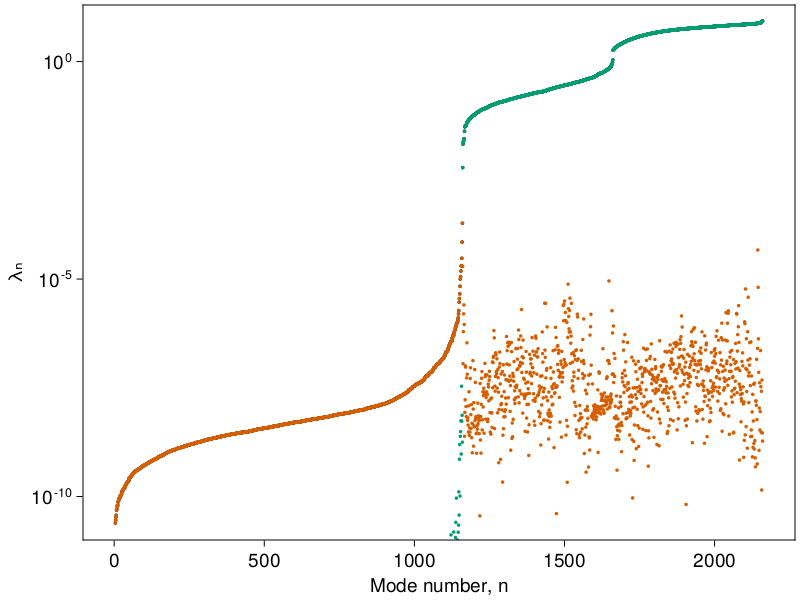

In [38]:
perm=sortperm((abs.(evH_3)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:2*nVerts], ((abs.(evH_3[perm])))[4:2*nVerts], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:2*nVerts], ((abs.(evmapLv_3[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evmapgX_3[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




# elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

# elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

# elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
# Legend(fig[1, 2],#
#     [elem_1, elem_2, elem_3],
#     ["","",""],
#     patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

ylims!(low=1e-11, high=2e1)
#Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

#fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","Mode_contributions_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

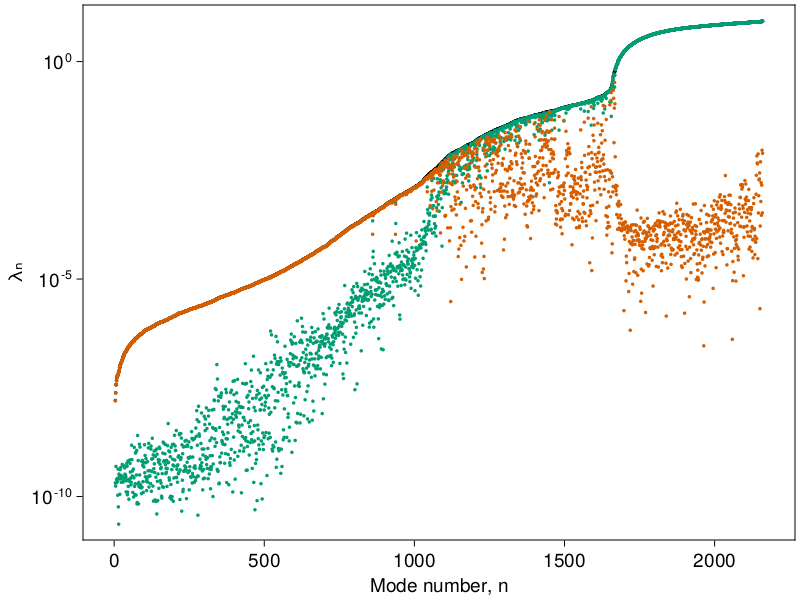

In [37]:
perm=sortperm((abs.(evH_29)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:2*nVerts], ((abs.(evH_29[perm])))[4:2*nVerts], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:2*nVerts], ((abs.(evmapLv_29[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evmapgX_29[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




# elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

# elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

# elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
# Legend(fig[1, 2],#
#     [elem_1, elem_2, elem_3],
#     ["","",""],
#     patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

ylims!(low=1e-11, high=2e1)
#Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

#fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","Mode_contributions_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

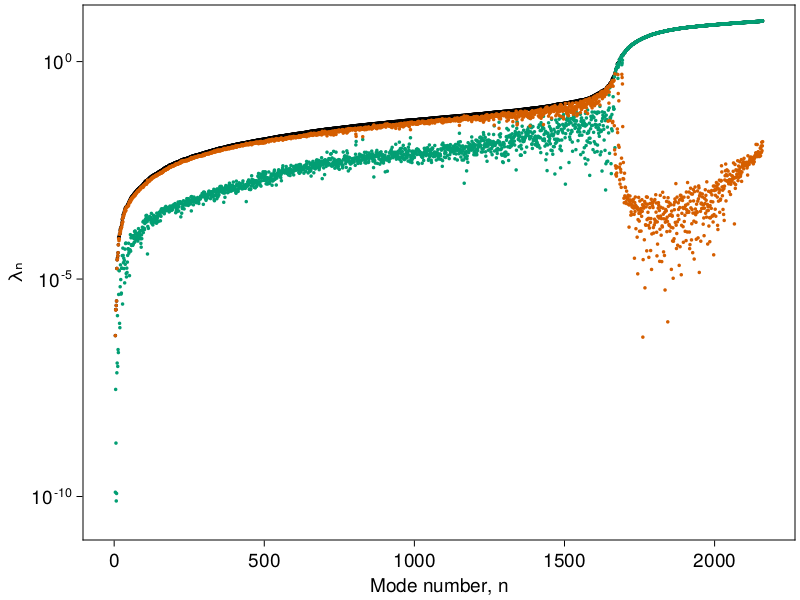

In [36]:
perm=sortperm((abs.(evH_285)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:2*nVerts], ((abs.(evH_285[perm])))[4:2*nVerts], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:2*nVerts], ((abs.(evmapLv_285[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evmapgX_285[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




# elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

# elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

# elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
# Legend(fig[1, 2],#
#     [elem_1, elem_2, elem_3],
#     ["","",""],
#     patchsize = (35, 35), rowgap = 10, framevisible = false)
# resize_to_layout!(fig)

ylims!(low=1e-11, high=2e1)
#Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

#fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","Mode_contributions_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

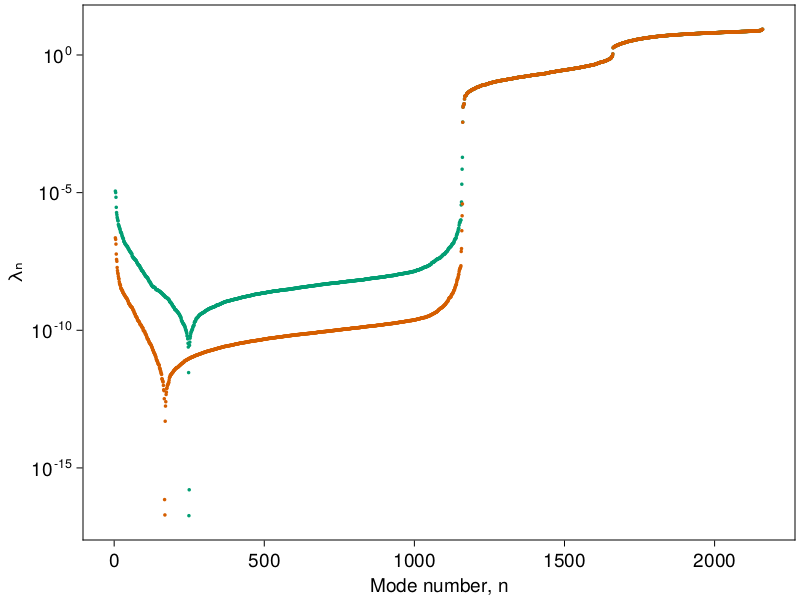

In [32]:
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:2*nVerts], ((abs.(evH_3)))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evalH0)))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")
fig
